In [1]:
import os
from os.path import join
import re
import sys
import subprocess
import numpy as np
import pandas as pd
import time
import matplotlib.colors as mcolors

import matplotlib.pyplot as plt
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import sklearn
import random
import string 
import scipy
import seaborn as sns
from pickle import load, dump
from collections import Counter

import pprint

import gensim
from gensim.models import word2vec, Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models import KeyedVectors
from gensim.utils import tokenize
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from wordcloud import WordCloud
from PIL import Image

import spacy

import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import unicodedata

import warnings
warnings.filterwarnings('ignore')

In [14]:
pd.options.display.max_colwidth = 2000

In [3]:
#!pip install wordcloud
#!pip install pyLDAvis!
#!pip install spacy
#!pip install langdetect
#!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
#!pip install unidecode

In [4]:
%matplotlib inline

In [5]:
os.getcwd()

'C:\\Users\\vnarv\\PycharmProjects\\twitter_text_mining\\notebooks'

In [4]:
#path = "/home/onyxia/twitter_text_mining/"
path = "C:/Users/vnarv/PycharmProjects/twitter_text_mining/"
os.chdir(path)

In [5]:
data = pd.read_csv(path + "/data/test/df_prepro_v2.csv", sep=";")

In [6]:
data.dtypes

datetime               object
tweet_id                int64
text                   object
username               object
like_count              int64
retweet_count           int64
reply_count             int64
quote_count             int64
date                   object
day                     int64
month                   int64
time                   object
hour                    int64
minute                  int64
hashtags               object
arrobas                object
text_clean             object
language               object
text_stem              object
text_stem_bigrame      object
text_stem_trigrame     object
text_lemma             object
text_lemma_bigrame     object
text_lemma_trigrame    object
dtype: object

In [9]:
#data = data[data["datetime"]>="2022-05-01"]

In [10]:
data.shape

(19743, 24)

In [10]:
data["datetime"].min()

'2022-02-01 08:44:30+00:00'

In [11]:
data["datetime"].max()

'2022-07-01 21:21:38+00:00'

In [12]:
data.describe()

tweet_id    like_count  retweet_count   reply_count   quote_count  \
count  1.973700e+04  19737.000000   19737.000000  19737.000000  19737.000000   
mean   1.506252e+18    368.715661      92.063586     25.045245     11.836196   
std    1.231714e+16   1829.680348     299.850573     84.871497     85.060240   
min    1.488433e+18      1.000000       3.000000      0.000000      0.000000   
25%    1.497928e+18     39.000000      20.000000      2.000000      1.000000   
50%    1.500884e+18     72.000000      31.000000      6.000000      2.000000   
75%    1.510580e+18    172.000000      62.000000     17.000000      5.000000   
max    1.542982e+18  76494.000000   15137.000000   3512.000000   6546.000000   

                day         month          hour        minute  
count  19737.000000  19737.000000  19737.000000  19737.000000  
mean      16.040178      3.165425     12.968232     28.119826  
std        9.415679      1.175795      5.037371     17.254370  
min        1.000000      2.000000      0.000000      0.000000  
25%        7.000000      2.000000      9.000000     13.000000  
50%       17.000000      3.000000     13.000000     28.000000  
75%       25.000000      4.000000     17.000000     43.000000  
max       31.000000      7.000000     22.000000     58.000000

In [14]:
data.columns

Index(['datetime', 'tweet_id', 'text', 'username', 'like_count',
       'retweet_count', 'reply_count', 'quote_count', 'date', 'day', 'month',
       'time', 'hour', 'minute', 'hashtags', 'arrobas', 'text_clean',
       'language', 'text_stem', 'text_stem_bigrame', 'text_stem_trigrame',
       'text_lemma', 'text_lemma_bigrame', 'text_lemma_trigrame'],
      dtype='object')

In [13]:
data["text"].iloc[0]

"voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc"

In [14]:
data["text"].iloc[0]

"voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc"

In [15]:
data["text_clean"].iloc[0]

'info malheureusement tres peu reprise medias entretien telephonique jours entre emmanuelmacron vladimirpoutine'

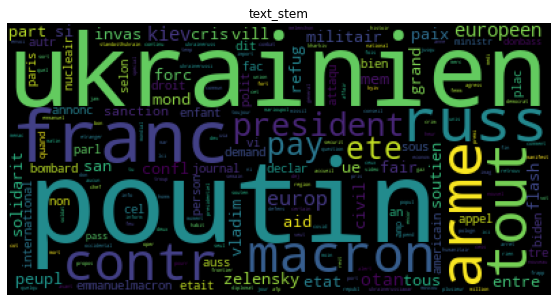

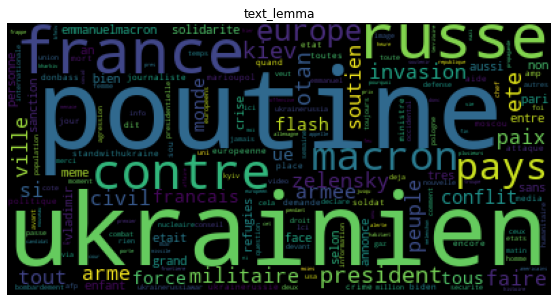

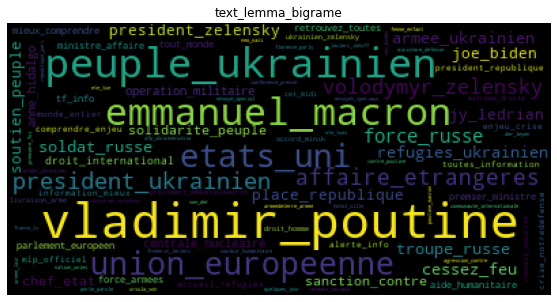

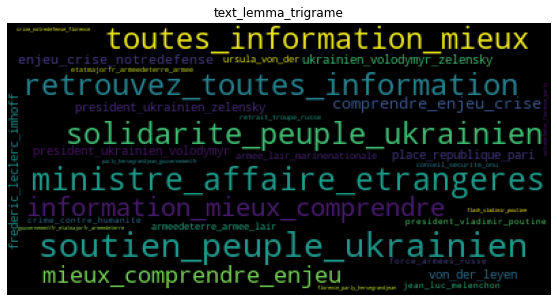

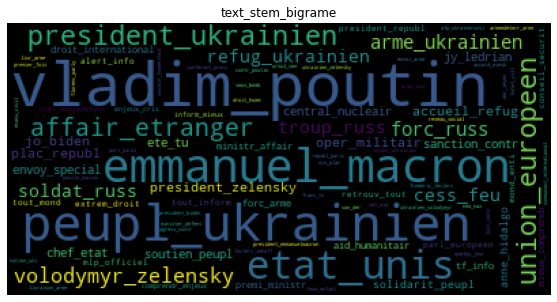

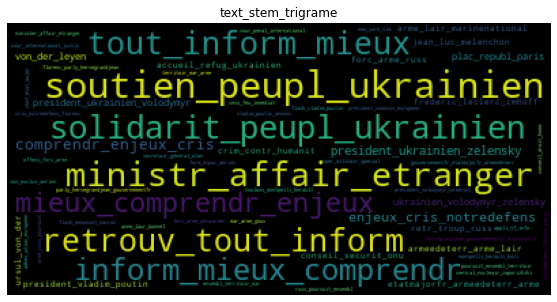

In [6]:
for method in ["text_stem", "text_lemma", "text_lemma_bigrame", "text_lemma_trigrame", "text_stem_bigrame", "text_stem_trigrame"]:
    words_t = ''
    for i in data[method]:
        try:
            words_t += '{} '.format(i.lower())
        except AttributeError:
            pass
    wd = pd.DataFrame(Counter(words_t.split()).most_common(), columns=['word', 'frequency_total'])
    tuples = [tuple(x) for x in wd.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.subplots(figsize=(10, 5)) 
    plt.imshow(wordcloud)
    plt.title(f"{method}") 
    plt.axis("off")
    plt.show()

In [ ]:
# point situation retrouvez information mieux comprendre

# LDA

In [8]:
def _clean_stop_words(df, list_stop_words):
    df = df.apply(
    lambda x: ' '.join([word for word in x.split() if word not in (
        list_stop_words)])
        )
    return df


# vectorize
def compute_bag_of_words(df):
    # split each tweet sentence into words
    text_tokens = [[text for text in tweet.split()] for tweet in df]
    # create a dictionary 
    dico_words = corpora.Dictionary(text_tokens)
    # Filter too common or rare words 
    dico_words.filter_extremes(no_below=10, no_above=0.95)
    # compute the frequency of each word in the dictionary
    doc_term_matrix = [dico_words.doc2bow(rev) for rev in text_tokens]
    
    return(text_tokens, dico_words, doc_term_matrix)


def compute_lda(dictionary, corpus, texts, num_topics):
    start = time.time()
    LDA = gensim.models.ldamodel.LdaModel
    # Build LDA model
    lda_model = LDA(
                corpus,
                id2word=dictionary,
                num_topics=num_topics,
                random_state=100,
                chunksize=100,
        alpha='auto',
        passes=20, per_word_topics=True)
    
    end = time.time()
    delta = (end- start)/60
    print(f"=== LDA model with {num_topics} topics took : {delta:.2} minutes")
    
    topics = []
    for idx, topic in lda_model.print_topics(-1) :
        print("Topic: {} -> Words: {}".format(idx, topic))
    topics.append(topic)
        
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'=== Coherence Score: {coherence_lda:.2}')
    #0.33063023037515266 baseline
    return lda_model, coherence_lda


def graph_nb_topics(start, limit, step, coherence_values, alias):
    x = range(start, limit, step)
    
    fig = plt.figure()
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.title(f"Coherence values for {alias}", size = 18)
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    fig.savefig(f"output/img/search_nbtopics_{alias}.png", dpi=200) 
    

def search_nb_topics(dictionary, corpus, texts, start, limit, step, alias):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # todo: transform into a function
        model = compute_lda(dictionary=dictionary,
                 corpus=corpus,
                 texts=texts,
                 num_topics=num_topics)
        coherence_values.append(model[1])
    
    # show graph
    best_topics = graph_nb_topics(start, limit, step, coherence_values, alias)
    
    best_values = [index for index, value in enumerate(coherence_values) if value == max(coherence_values)]
    
    return best_values[0] + start


# Assign a topic to each tweet 
def _format_topics_sentences(ldamodel, corpus, texts):
        
        # Init output
        sent_topics_df = pd.DataFrame()

        start = time.time()
        # Get main topic in each document
        for i, row_list in enumerate(ldamodel[corpus]):
            # per_word_topics: list of topics, sorted in descending order of most likely topics for each word
            row = row_list[0] if ldamodel.per_word_topics else row_list
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        end = time.time()
        delta = (end - start)/60
        print(f"Format topics took {delta:.2} minutes")
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
        
        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

        # format
        sent_topics_df = sent_topics_df.reset_index()
        sent_topics_df.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'tokens']
        return(sent_topics_df) 
    
def graph_topics(lda_result, df_dominant_topics, alias):

    topics = lda_result.show_topics(formatted=False, num_words=20)
    data_flat = [w for w_list in df_dominant_topics["tokens"] for w in w_list]
    counter = Counter(data_flat)

    all_ = pd.DataFrame()
    for i, topic in topics:
        for word, weight in topic:
            tmp = pd.DataFrame([[word, i, weight, counter[word]]],
                               columns=["keyword", "topic", "weight", "word_count"]
                              )
            all_ = pd.concat([all_, tmp], axis=0)


    # Plot Word Count and Weights of Topic Keywords
    ncols = 2
    nrows = len(all_["topic"].unique()) // ncols + (len(all_["topic"].unique()) % ncols > 0)
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(f"{alias} : Word counts and weights for each topic")
    #fig, axes = plt.subplots(nrows, ncols, figsize=(20,15), sharey=True, dpi=100)
    #cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, topic in enumerate(all_["topic"].unique()):
        ax = plt.subplot(nrows, ncols, i + 1)
        
        ax.bar(x='keyword', height="word_count", data=all_.loc[all_["topic"]==topic, :],
           #color=cols[i],
           width=0.5, alpha=0.5)
        ax_twin = ax.twinx()
        ax_twin.scatter(x='keyword', y="weight", data=all_.loc[all_["topic"]==topic, :], 
                    color="C7",
                    label="Weights")

        ax.set_ylabel('Word Count',)
                      #color=cols[i])
        ax_twin.set_ylim(0,  (all_["weight"].max() + 0.02))
        ax.set_ylim(0, all_["word_count"].max() + 100)
        ax.set_title("Topic: " + str(all_["topic"].unique()), #color=cols[i],
                     fontsize=16)
        ax.tick_params(axis="y", left=False)
        ax.set_xticklabels(all_.loc[all_["topic"]==topic, "keyword"], rotation=30, horizontalalignment= "right")

        ax.legend(loc='upper left', fontsize=10)
        ax_twin.legend(loc='upper right', fontsize=10)
        fig.tight_layout()
        # This line will delete the last empty plot
    #fig.delaxes(ax= axes[1,2])
    fig.savefig(f"output/img/{alias}.png", dpi=200) 

def compute_word_cloud(df, text, alias):
    
    color_list = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    #color_list_gl = ["summer", "winter", "Oranges", "seismic"]

    cloud = WordCloud(
        #background_color='white',
                      width=2500,
                      height=1800,
                      max_words=200,
                      colormap="Oranges",
                      color_func=lambda *args, **kwargs: color_list[i],
                      prefer_horizontal=1.0)
    
    ncols = 2
    nrows = len(df["dominant_topic"].unique()) // ncols + (len(df["dominant_topic"].unique()) % ncols > 0)
    fig = plt.figure(figsize=(20, 20))
    #plt.subplots_adjust(hspace=0.9)
    fig.suptitle(f"World Cloud for {text}", fontsize=18, y=0.95)
    plt.tight_layout()
    #fig, axes = plt.subplots(nrows, ncols, figsize=(15,15), sharex=True, sharey=True)

    #for i, ax in enumerate(axes.flatten()):
    for i, variable in enumerate(df["dominant_topic"].unique()):
    # add a new subplot iteratively
        ax = plt.subplot(nrows, ncols, i + 1)
        #fig.add_subplot(ax)
        cloud.generate(str(
                df[df["dominant_topic"]==i][text].values))
        plt.gca().imshow(cloud, interpolation="bilinear")
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
        
    plt.savefig(f"output/img/world_cloud_{alias}.png")
    
        


In [9]:
def run_all(df_tweets, text, alias, do_search_best_topics, nb_topics=0):
    
    # filter only the necessary columns and drop nan
    df_tweets = df_tweets[["tweet_id", "text", "username", text]]
    df_tweets = df_tweets[~(df_tweets[text].isna())]
    df_tweets = df_tweets.reset_index()
    
    start_run = time.time()
    print(f"===== Method : {alias} =====")  
    print("... Running bag of words")
    text_tokens, dico_words, doc_term_matrix = compute_bag_of_words(df_tweets[text])
    
    if do_search_best_topics:
        # search best nb of topics
        print("... Running search for best nb of topics")
        best_topics = search_nb_topics(dictionary=dico_words,
                                           corpus=doc_term_matrix,
                                           texts=text_tokens,
                                           start=2, limit=7, step=1,
                                           alias=alias)
    else:
        best_topics = nb_topics
        
    # run lda model
    print(f"... Running lda with {best_topics} topics")
    lda_result, score = compute_lda(dictionary=dico_words,
                                         corpus=doc_term_matrix,
                                         texts=text_tokens,
                                         num_topics=best_topics)
    
    print(f"... Running lda visualization")
    vis = gensimvis.prepare(topic_model=lda_result,
                            corpus=doc_term_matrix,
                            dictionary=dico_words)
    pyLDAvis.enable_notebook()
    #pyLDAvis.display(vis)
    pyLDAvis.save_html(vis, f'output/img/lda_{alias}_{best_topics}topics.html')
    
    print(f"... Running dominant topics")
    df_dominant_topics = _format_topics_sentences(ldamodel=lda_result,
                                                 corpus=doc_term_matrix,
                                                 texts=text_tokens)
                          
    df_dominant_topics_ = df_tweets.join(df_dominant_topics, how="inner" )
    df_dominant_topics_ = df_dominant_topics_.set_index("tweet_id")
    
    df_dominant_topics_.to_csv(f"output/dominant_topics_{alias}_{best_topics}topics.csv",
                              sep=";")
    
    print("... Graph topics and keywords")
    graph_topics(lda_result, df_dominant_topics_, alias)
    
    print("... Graph word cloud for each topic")
    compute_word_cloud(df_dominant_topics_, text, alias)
    
    end_run = time.time()
    
    running_time = (end_run - start_run)/60
    
    print(f"\n Total running time: {running_time} minutes")
    
    return df_dominant_topics_

## Lemmatization

===== Method : lemma =====
... Running bag of words
... Running search for best nb of topics
=== LDA model with 2 topics took : 1.0 minutes
Topic: 0 -> Words: 0.013*"poutine" + 0.013*"macron" + 0.011*"ukrainien" + 0.009*"russe" + 0.008*"ete" + 0.008*"zelensky" + 0.007*"kiev" + 0.007*"arme" + 0.007*"otan" + 0.006*"armee"
Topic: 1 -> Words: 0.022*"france" + 0.015*"europe" + 0.014*"ue" + 0.012*"ukrainien" + 0.009*"soutien" + 0.008*"emmanuelmacron" + 0.007*"amp" + 0.007*"tous" + 0.006*"candidat" + 0.006*"contre"
=== Coherence Score: 0.2
=== LDA model with 3 topics took : 0.97 minutes
Topic: 0 -> Words: 0.021*"poutine" + 0.013*"contre" + 0.013*"macron" + 0.013*"ue" + 0.010*"otan" + 0.008*"faire" + 0.008*"tout" + 0.008*"si" + 0.007*"an" + 0.007*"conflit"
Topic: 1 -> Words: 0.020*"ukrainien" + 0.020*"russe" + 0.018*"ete" + 0.016*"kiev" + 0.014*"armee" + 0.012*"civil" + 0.011*"militaire" + 0.010*"donbass" + 0.010*"mort" + 0.009*"force"
Topic: 2 -> Words: 0.026*"france" + 0.017*"ukrainien" + 0.

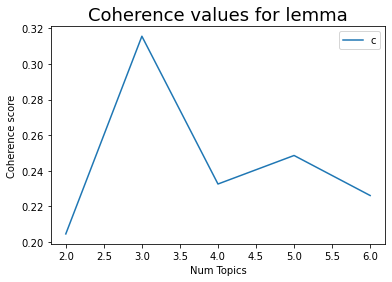

... Running lda with 3 topics
=== LDA model with 3 topics took : 0.97 minutes
Topic: 0 -> Words: 0.021*"poutine" + 0.013*"contre" + 0.013*"macron" + 0.013*"ue" + 0.010*"otan" + 0.008*"faire" + 0.008*"tout" + 0.008*"si" + 0.007*"an" + 0.007*"conflit"
Topic: 1 -> Words: 0.020*"ukrainien" + 0.020*"russe" + 0.018*"ete" + 0.016*"kiev" + 0.014*"armee" + 0.012*"civil" + 0.011*"militaire" + 0.010*"donbass" + 0.010*"mort" + 0.009*"force"
Topic: 2 -> Words: 0.026*"france" + 0.017*"ukrainien" + 0.015*"zelensky" + 0.013*"president" + 0.012*"europe" + 0.011*"soutien" + 0.010*"francais" + 0.010*"emmanuelmacron" + 0.010*"macron" + 0.008*"sans"
=== Coherence Score: 0.32
... Running lda visualization
... Running dominant topics
Format topics took 1e+01 minutes
... Graph topics and keywords


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


... Graph word cloud for each topic

 Total running time: 17.863826668262483 minutes


index  \
tweet_id                     
1488433061196812291      0   
1488447673883676672      1   
1488493240475078658      2   
1488502446771081216      3   
1488511509961527302      4   
...                    ...   
1542967067611127813  19732   
1542963887175335937  19733   
1542971236459888641  19734   
1542969041161158656  19735   
1542981780092985344  19736   

                                                                                                                                                                                                                                                                                                                                        text  \
tweet_id                                                                                                                                                                                                                                                                                                                                       
1488433061196812291                                                                                                                               voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc   
1488447673883676672                                                                                                                                                                                                                                               #ukraine face à poutine ... macron hausse le ton ! https://t.co/mfpsevidlv   
1488493240475078658                                                                          crise en #ukraine : « emmanuel #macron et vladimir #poutine, se sont reparlés hier soir. il y a un dialogue et des échanges nourris. on veut éviter un conflit armé à nos portes. c'est encore possible » @gabrielattal https://t.co/v7ovwb9n4i   
1488502446771081216                           la #russie c'est l'équivalent du pib de l'italie. attention aux sanctions qu'elle pourrait recevoir et monsieur poutine est réaliste. on a loupé la relation avec la russie il y a une quinzaine d'années : elle devra être reconstruite dans l'avenir. #kiev #ukraine https://t.co/b15g66ehvl   
1488511509961527302                                                                                                                                                      crise en #ukraine : voilà pourquoi il faut sortir du piège atlantiste, refuser la guerre et quitter l’otan sur le champ ! nouvelle vidéo ➡️ https://t.co/qjyacvg9pk   
...                                                                                                                                                                                                                                                                                                                                      ...   
1542967067611127813                                                                                                                                                                                                                                    c'est magnifique et tellement émouvant 🥰🇺🇦🇪🇺 #ukraine #europe https://t.co/0ywt0zwqot   
1542963887175335937  👉 guerre un #ukraine : que faire pour aider les populations ?\r\n\r\n🗣️ @vpecresse \r\n"il y a urgence : l'hiver qui arrive. il faut mettre à l'abri les populations, reconstruire avant l'hiver [...] il faut investir massivement dans les régions libérées."\r\n\r\n📺 #le20hdedariusrochebin https://t.co/rh8jkshhcs   
1542971236459888641          👉 guerre en #ukraine : le soft power des réseaux sociaux\r\n\r\n🗣️ @vpecresse\r\n\r\n"on peut organiser le chaos à partir de ce soft power des réseaux sociaux [...] on le voit d'ailleurs car nos extrémistes sont plutôt pro russes."\r\n\r\n📺 

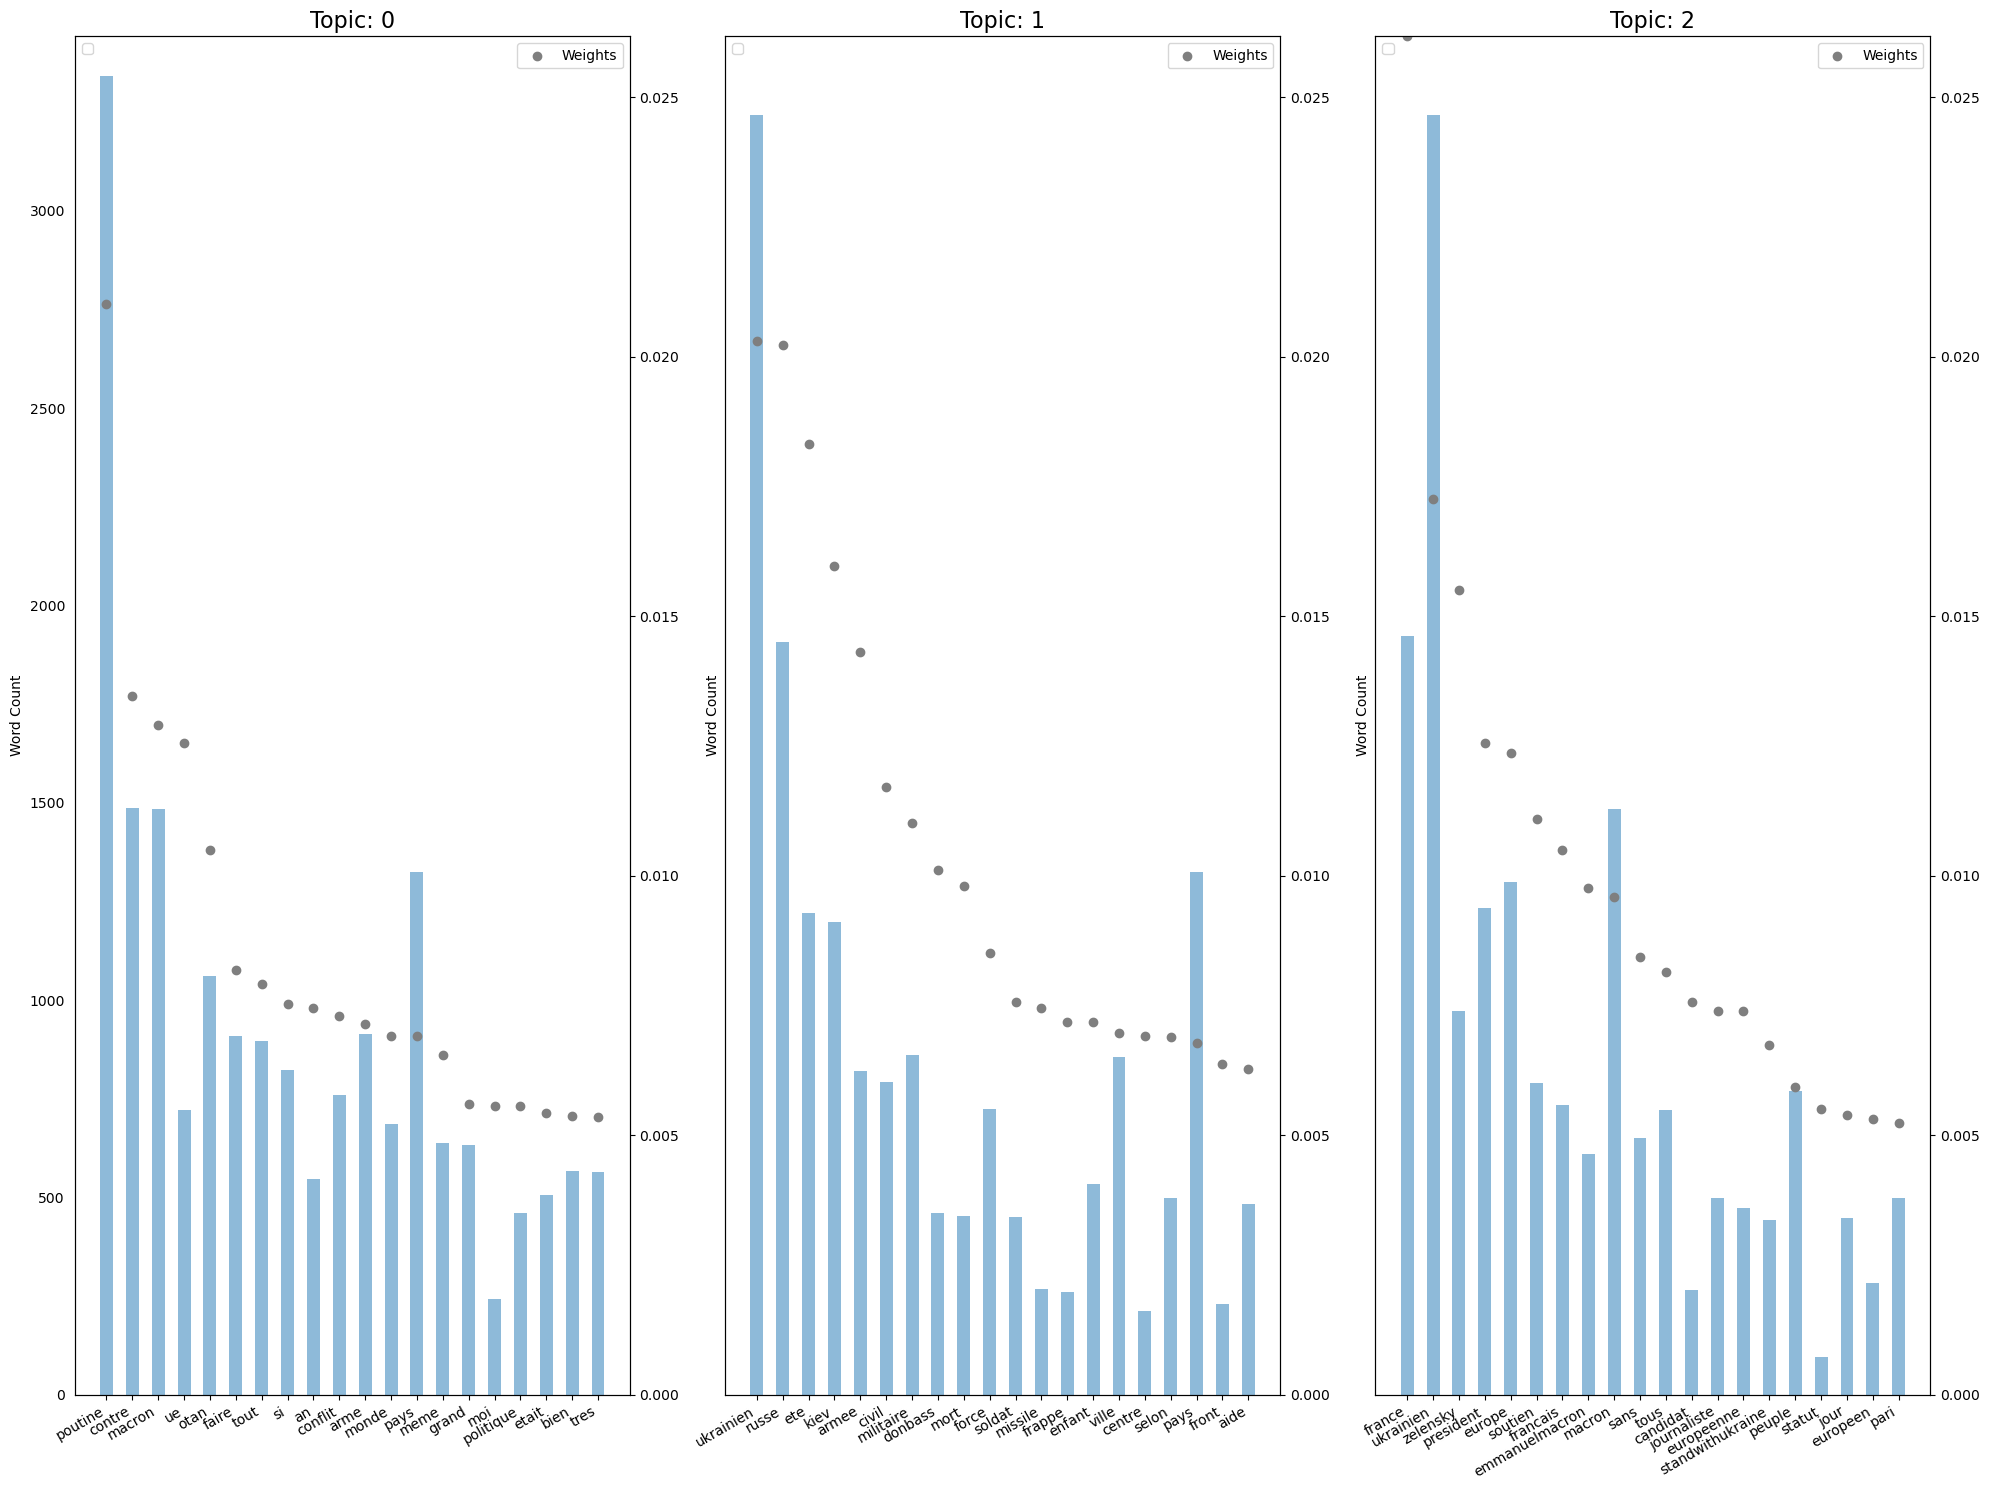

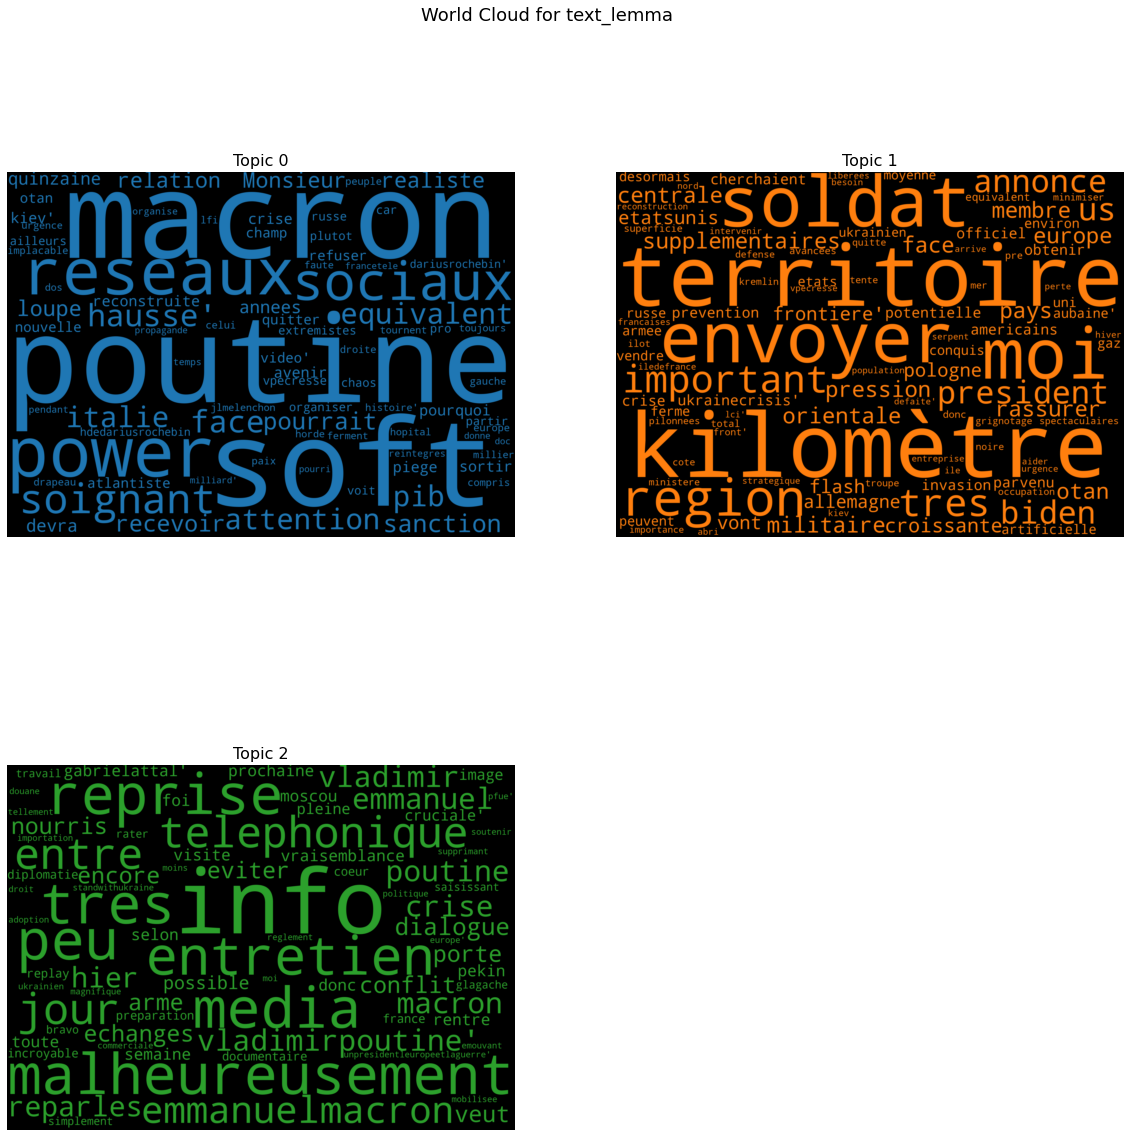

In [21]:
run_all(data.copy(deep=True), "text_lemma", "lemma", True)

### - 3 topics

In [24]:
df_lemma_3topics = pd.read_csv("~/PycharmProjects/twitter_text_mining/output/dominant_topics_lemma_3topics.csv",
                              sep=";")

In [ ]:
# plus, comme, peut, va, etre, fait, alors, leurs, ver, juin, dont, soir 

In [26]:
for i in df_lemma_3topics["dominant_topic"].unique():
    display(df_lemma_3topics[df_lemma_3topics["dominant_topic"]==i].sort_values(by=["dominant_topic", "topic_perc_contrib"], ascending=[True, False]).head(20))

tweet_id  index  \
6786   1498672959241793546   6786   
7996   1499362621249757195   7996   
8096   1499419499174449155   8096   
7267   1498935558650875906   7267   
5951   1498315056886464516   5951   
1255   1496171401228738561   1255   
6518   1498597255816884225   6518   
18621  1534887226664001536  18623   
3803   1497458464754446336   3803   
1620   1496735933927870465   1620   
13948  1507429047302869000  13950   
13468  1506636575769346058  13470   
3423   1497234797088972805   3423   
5910   1498302454424907781   5910   
48     1489628469315215363     48   
9106   1500164119890169865   9107   
9129   1500179637426659340   9130   
8375   1499660052738846723   8375   
6058   1498345843044323331   6058   
1482   1496672807840792580   1482   

                                                                                                                                                                                                                                                                                                                                text  \
6786                   #directan 🇨🇵🇺🇦\r\nl'ambassadeur d’#ukraine en france @omelchenkovadym ovationné par la représentation nationale @assembleenat.\r\n\r\nsolidarité unanime et historique des députés français avec le peuple ukrainien qui se bat pour sa souveraineté et sa liberté. #standwithukraine https://t.co/hoq9nnimkw   
7996     📰 communiqué de presse commun avec @gnrt_rennes et @eelv_rennes sur la guerre en #ukraine\r\n✅ condamnation de l'invasion de l'ukraine\r\n✅ soutien au peuple ukrainien\r\n✅ soutien à l'action de l'union européenne @uefrance\r\n➡️ rassemblement le 05 mars à 15h à #rennes\r\n#standwithukraine https://t.co/zpzwdveayt   
8096                                             🇺🇦 guerre en #ukraine : @artefr se mobilise avec\r\nune journée spéciale samedi 5 mars\r\nun nouveau rdv quotidien du #dessousdescartes dès le 7 mars à 20h50 un concert en soutien au peuple ukrainien vendredi 4 mars.\r\nle cp ➡ https://t.co/xbztx7o4xw https://t.co/heu3r00a8a   
7267   🔴 bientôt à la #hrc49.\r\n\r\nle conseil des droits de l'homme de l'@onu_fr🇺🇳tiendra un débat d'urgence sur « la situation des droits de l'homme en #ukraine découlant de l’agression russe ».\r\n\r\n🗓jeudi 3 mars 2022 à 15h cet.\r\nℹ️ programme de travail : https://t.co/qcw6tegjme\r\n📺@unwebtv https://t.co/v6gm3ao7v3   
5951                                                                                           🔴 en direct | suivez la réunion d’urgence de l’assemblée générale des nations unies sur l’#ukraine et regardez l’intervention du représentant permanent de la france auprès des nations unies @nderiviere.\r\nhttps://t.co/gxi8csxzvp   
1255                                                                                   🔴 direct | conférence de presse conjointe depuis paris de @josepborrellf et @jy_ledrian à l’issue de la réunion informelle extraordinaire des ministres des affaires étrangères de l’union européenne\r\n\r\n#ukraine https://t.co/onytnr1pzg   
6518                           🔴 bientôt à la #hrc49.\r\n\r\nle conseil des droits de l'homme de l'@onu_fr🇺🇳tiendra un débat d'urgence sur « la situation des droits de l'homme en #ukraine découlant de l’agression russe ».\r\n\r\n🗓jeudi 3 mars 2022\r\nℹ️ programme de travail : https://t.co/ejiyvyq8pd https://t.co/t7twzahumf   
18621                hier, avec @anne_hidalgo, au meeting de @lamiaela dans le 20e arrondissement de #paris, qui s’est engagée fermement aux côtés des #ukrainiens en signant notre charte de soutien à l’#ukraine proposée à tous les candidats @ukrainestand #legislative2022 #legislatives2022 #circo7515 https://t.co/po8wzholj4   
3803                                                       rassemblement citoyen pour la paix en #ukraine ce samedi 26 février, 15h30, place de la république à #rennes.  mobilisons-nous pour y participer et défendre la paix, la liberté et la démocratie en ukraine et aussi en europe! ! #s

tweet_id  index  \
19593  1541862765941460995  19595   
5664   1498223395909120001   5664   
19384  1540352625824202754  19386   
13578  1506709003367297042  13580   
1404   1496458764890910725   1404   
586    1494955688195416065    586   
3502   1497257429956009987   3502   
6096   1498352403162275848   6096   
1524   1496696879979143172   1524   
5927   1498309450368786435   5927   
18461  1533337539775545344  18463   
3934   1497511215911817216   3934   
4995   1497935383589498885   4995   
11434  1502917947278630912  11436   
5756   1498244198922870786   5756   
10589  1501657803454353411  10591   
11031  1502288574917615616  11033   
2002   1496802415118630913   2002   
1096   1496032696950214659   1096   
7824   1499289186066698241   7824   

                                                                                                                                                                                                                                                                                                           text  \
19593              comment voulez-vous faire la leçon à la #russie sur leurs crimes de guerre en #ukraine quand on minimise les crimes de guerre de nos alliés? #poutine utilise en + la même propagande que certains régimes "amis"\r\n#yemen #palestine #irak #lybie #afghanistan \r\nhttps://t.co/9t01rxjppc   
5664                  alain bauer, tjrs pédagogue, explique comment on est arrivé à la situation actuelle en #ukraine .on découvre que ce n'est pas uniquement la responsabilité d'un #poutine autoritaire mais aussi d'un otan expansionniste, des accords non respectés et l'armement de l'ukraine\r\n#hdpros   
19384                                  pendant que tu galères à payer ton plein d'essence, n'oublie pas qu' "en même temps", nos pauvres actionnaires beaucoup trop imposés par l'état voient leurs dividendes augmenter de très peu. via @humanite_fr #essence #macron #nupes #ukraine https://t.co/kavbrg1cls   
13578                  7. telle est la stratégie de moyen/long terme de #biden, qui est accentuée par cette attribution de crimes de guerre à la #russie en #ukraine. avec 1 revers éventuel: 1 #poutine acculé et promis- de fait- à 1 tpi ne pourrait-il choisir au contraire un "perdu pour perdu"? #àsuivre   
1404              le kremlin se sert du signalement de masse twitter pour exclure des expert.e.s osint de la plateforme. \r\nsignalement de masse =&gt; algos auto-apprenants =&gt; normalisation des comportements déviants =&gt; système de strikes =&gt; ban définitif. \r\n#ukraine https://t.co/wbed38gusj   
586                                           #ukraine est-il maintenant assez clair que les auto-proclamés "patriotes" (#rn #reconquête et d'une certaine façon #lfi) sont l'éternel parti des traîtres ? leurs grands-parents voulaient une europe allemande, ils veulent une europe russe. #cinquièmecolonne   
3502                                               et voilà.....on le menace de s'en prendre à ses biens et il démissionne enfin. vous voyez quand on prend les gens par les sentiments. a droite et à l'extrême droite il ne faut pas parler patriotisme  mais pognon #fillon #ukraine https://t.co/0q2tkx639r   
6096                         #macron c'est la plus grande crise intérieure avec les #giletsjaunes, la plus grande pandémie avec le #covid_19 , et le plus grand conflit en europe avec l'#ukraine depuis 1945 ... ce mec est le chat noir du monde. les 7 plaies d'égypte, j'attend l'invasion des criquets ...   
1524         #poutine remarque que les usa ont déclenché une guerre impérialiste en irak sur des accusations hypocrites d’armes chimiques inventées.\r\n\r\nle hoax des armes chimiques démontre l’hypocrisie de l’otan qui justifie toujours ses guerres impérialistes derrière des mensonges \r\n\r\n#ukraine   
5927                                        poutine fustige "l'empire du mensonge" occidental sur la télé publique après les sanctions frappant la russie en raison de l'i

tweet_id  index  \
11597  1503053273451827201  11599   
6286   1498423657298907144   6286   
10121  1501215909163241474  10122   
4533   1497689509747736577   4533   
3311   1497205096618283008   3311   
9369   1500444602112921600   9370   
11636  1503083474466521092  11638   
2566   1496917959125741574   2566   
11577  1503043478212816907  11579   
9563   1500574931460968450   9564   
9860   1500883660517658629   9861   
5081   1497963107796324353   5081   
6944   1498706070973431808   6944   
7617   1499104206183182340   7617   
5924   1498311364472938506   5924   
3136   1497171414880763908   3136   
4151   1497562196829687813   4151   
7748   1499148855463526404   7748   
7487   1499038903633854466   7487   
3893   1497495954127306754   3893   

                                                                                                                                                                                                                                                                                                                     text  \
11597    [a la une a 18h]  \r\n#ukraine : de nouvelles frappes russes ont visé dans la nuit une base militaire près de la frontière polonaise, faisant au moins 35 morts selon les autorités locales, tandis que près de kiev, un journaliste américain a été tué par balle #afp #afpgraphics 1/5 https://t.co/jiqtduz0y0   
6286                           l'armée ukrainienne a détruit 100 chars et camions militaires russes avec des bombardements de précision des avions bayraktar et de l'artillerie lourde dans le nord de l'ukraine.\r\ncommandement des opérations du nord de l'armée ukrainienne\r\n#guerre_ukrainienne_russe \r\n#ukraine   
10121                ℹ️sur le front nord :\r\n\r\n#soumy :\r\n• okhtyrka serait encerclée par les forces russes (75km\r\nau sud de soumy).\r\n\r\n#chernihiv :\r\n• l’armée ukrainienne est prise en tenaille dans la\r\nrégion de nizhnyn (50km au sud-est de tchernihiv).\r\n\r\n#ukraine [5/6] https://t.co/oh0jn6bhg5   
4533                                                                                                            🇺🇦🇷🇺 [alerte] l'hôpital pour enfants d'#okhmadyt a été touché par un tir de la #russie. bilan : un enfant mort, deux enfants et deux adultes blessés. (autorités locales) #ukraine #kiev #ukraineinvasion   
3311                                              ⚡ flash - #ukraine : les troupes russes à l'approche de #kherson, ville du sud de l'ukraine et la capitale administrative de l'#oblast de kherson. #worldwar3 #ukraineinvasion #ukrainerussia #ukrainerussie #russiaukraineconflict #ukrainewar https://t.co/eqjfoxzqzx   
9369                    🇺🇦 #ukraine - le point sur la situation [a dérouler]\r\n\r\nune nouvelle tentative pour évacuer des civils du port stratégique ukrainien de marioupol, assiégé par les troupes russes, est prévue aujourd'hui alors que de violents combats font rage autour de kiev #afp https://t.co/65t0ic4gaw   
11636         [a la une a 20h]  \r\n#ukraine : de nouvelles frappes russes ont visé une base militaire près de la frontière polonaise, faisant au moins 35 morts selon les autorités locales, tandis que près de kiev, un journaliste américain a été tué et un autre blessé par balles  #afp 1/5 https://t.co/iyxn4wgulq   
2566                                                          selon @iaponomarenko reporter défense au @kyivindependent, la base militaire ukrainienne de l'ile aux serpents, au niveau du delta du danube, mer noire, a la frontière #ukraine #roumanie, a été détruite par les russes.  \r\n\r\nhttps://t.co/moqsjizsrq   
11577                                ℹ️ sur le front nord : zone de combat principale\r\n#lviv :\r\n• un centre d’entraînement militaire a été pris pour cible dans le nord-ouest de la ville.\r\n#ivanofrankisvk :\r\n• la base aérienne a subi de nouveaux bombardements.\r\n\r\n#ukraine [2/5] https://t.co/ole3gh0pql   
9563                     sur le front est : zone de progression des fo

## Lemma bigrame

===== Method : lemma_bigrame =====
... Running bag of words
... Running lda with 4 topics
=== LDA model with 4 topics took : 0.56 minutes
Topic: 0 -> Words: 0.053*"emmanuel_macron" + 0.042*"vladimir_poutine" + 0.026*"peuple_ukrainien" + 0.022*"armee_ukrainien" + 0.016*"ukrainien_standwithukraine" + 0.015*"chef_etat" + 0.014*"president_zelensky" + 0.013*"soldat_russe" + 0.012*"parlement_europeen" + 0.011*"france_tv"
Topic: 1 -> Words: 0.047*"statut_candidat" + 0.033*"volodymyr_zelensky" + 0.022*"affaire_etrangeres" + 0.020*"ministere_defense" + 0.019*"pendant_temps" + 0.017*"frederic_leclerc" + 0.017*"leclerc_imhoff" + 0.017*"president_emmanuelmacron" + 0.014*"journaliste_francais" + 0.014*"candidat_ue"
Topic: 2 -> Words: 0.041*"union_europeenne" + 0.027*"centre_commercial" + 0.022*"mieux_comprendre" + 0.021*"retrouvez_toutes" + 0.021*"toutes_information" + 0.021*"comprendre_enjeu" + 0.021*"enjeu_crise" + 0.021*"crise_notredefense" + 0.021*"information_mieux" + 0.020*"armeedeterre_armee

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


... Graph word cloud for each topic

 Total running time: 9.607948354880016 minutes


index  \
tweet_id                     
1488433061196812291      0   
1488447673883676672      1   
1488493240475078658      2   
1488502446771081216      3   
1488511509961527302      4   
...                    ...   
1542967067611127813  19732   
1542963887175335937  19733   
1542971236459888641  19734   
1542969041161158656  19735   
1542981780092985344  19736   

                                                                                                                                                                                                                                                                                                                                        text  \
tweet_id                                                                                                                                                                                                                                                                                                                                       
1488433061196812291                                                                                                                               voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc   
1488447673883676672                                                                                                                                                                                                                                               #ukraine face à poutine ... macron hausse le ton ! https://t.co/mfpsevidlv   
1488493240475078658                                                                          crise en #ukraine : « emmanuel #macron et vladimir #poutine, se sont reparlés hier soir. il y a un dialogue et des échanges nourris. on veut éviter un conflit armé à nos portes. c'est encore possible » @gabrielattal https://t.co/v7ovwb9n4i   
1488502446771081216                           la #russie c'est l'équivalent du pib de l'italie. attention aux sanctions qu'elle pourrait recevoir et monsieur poutine est réaliste. on a loupé la relation avec la russie il y a une quinzaine d'années : elle devra être reconstruite dans l'avenir. #kiev #ukraine https://t.co/b15g66ehvl   
1488511509961527302                                                                                                                                                      crise en #ukraine : voilà pourquoi il faut sortir du piège atlantiste, refuser la guerre et quitter l’otan sur le champ ! nouvelle vidéo ➡️ https://t.co/qjyacvg9pk   
...                                                                                                                                                                                                                                                                                                                                      ...   
1542967067611127813                                                                                                                                                                                                                                    c'est magnifique et tellement émouvant 🥰🇺🇦🇪🇺 #ukraine #europe https://t.co/0ywt0zwqot   
1542963887175335937  👉 guerre un #ukraine : que faire pour aider les populations ?\r\n\r\n🗣️ @vpecresse \r\n"il y a urgence : l'hiver qui arrive. il faut mettre à l'abri les populations, reconstruire avant l'hiver [...] il faut investir massivement dans les régions libérées."\r\n\r\n📺 #le20hdedariusrochebin https://t.co/rh8jkshhcs   
1542971236459888641          👉 guerre en #ukraine : le soft power des réseaux sociaux\r\n\r\n🗣️ @vpecresse\r\n\r\n"on peut organiser le chaos à partir de ce soft power des réseaux sociaux [...] on le voit d'ailleurs car nos extrémistes sont plutôt pro russes."\r\n\r\n📺 

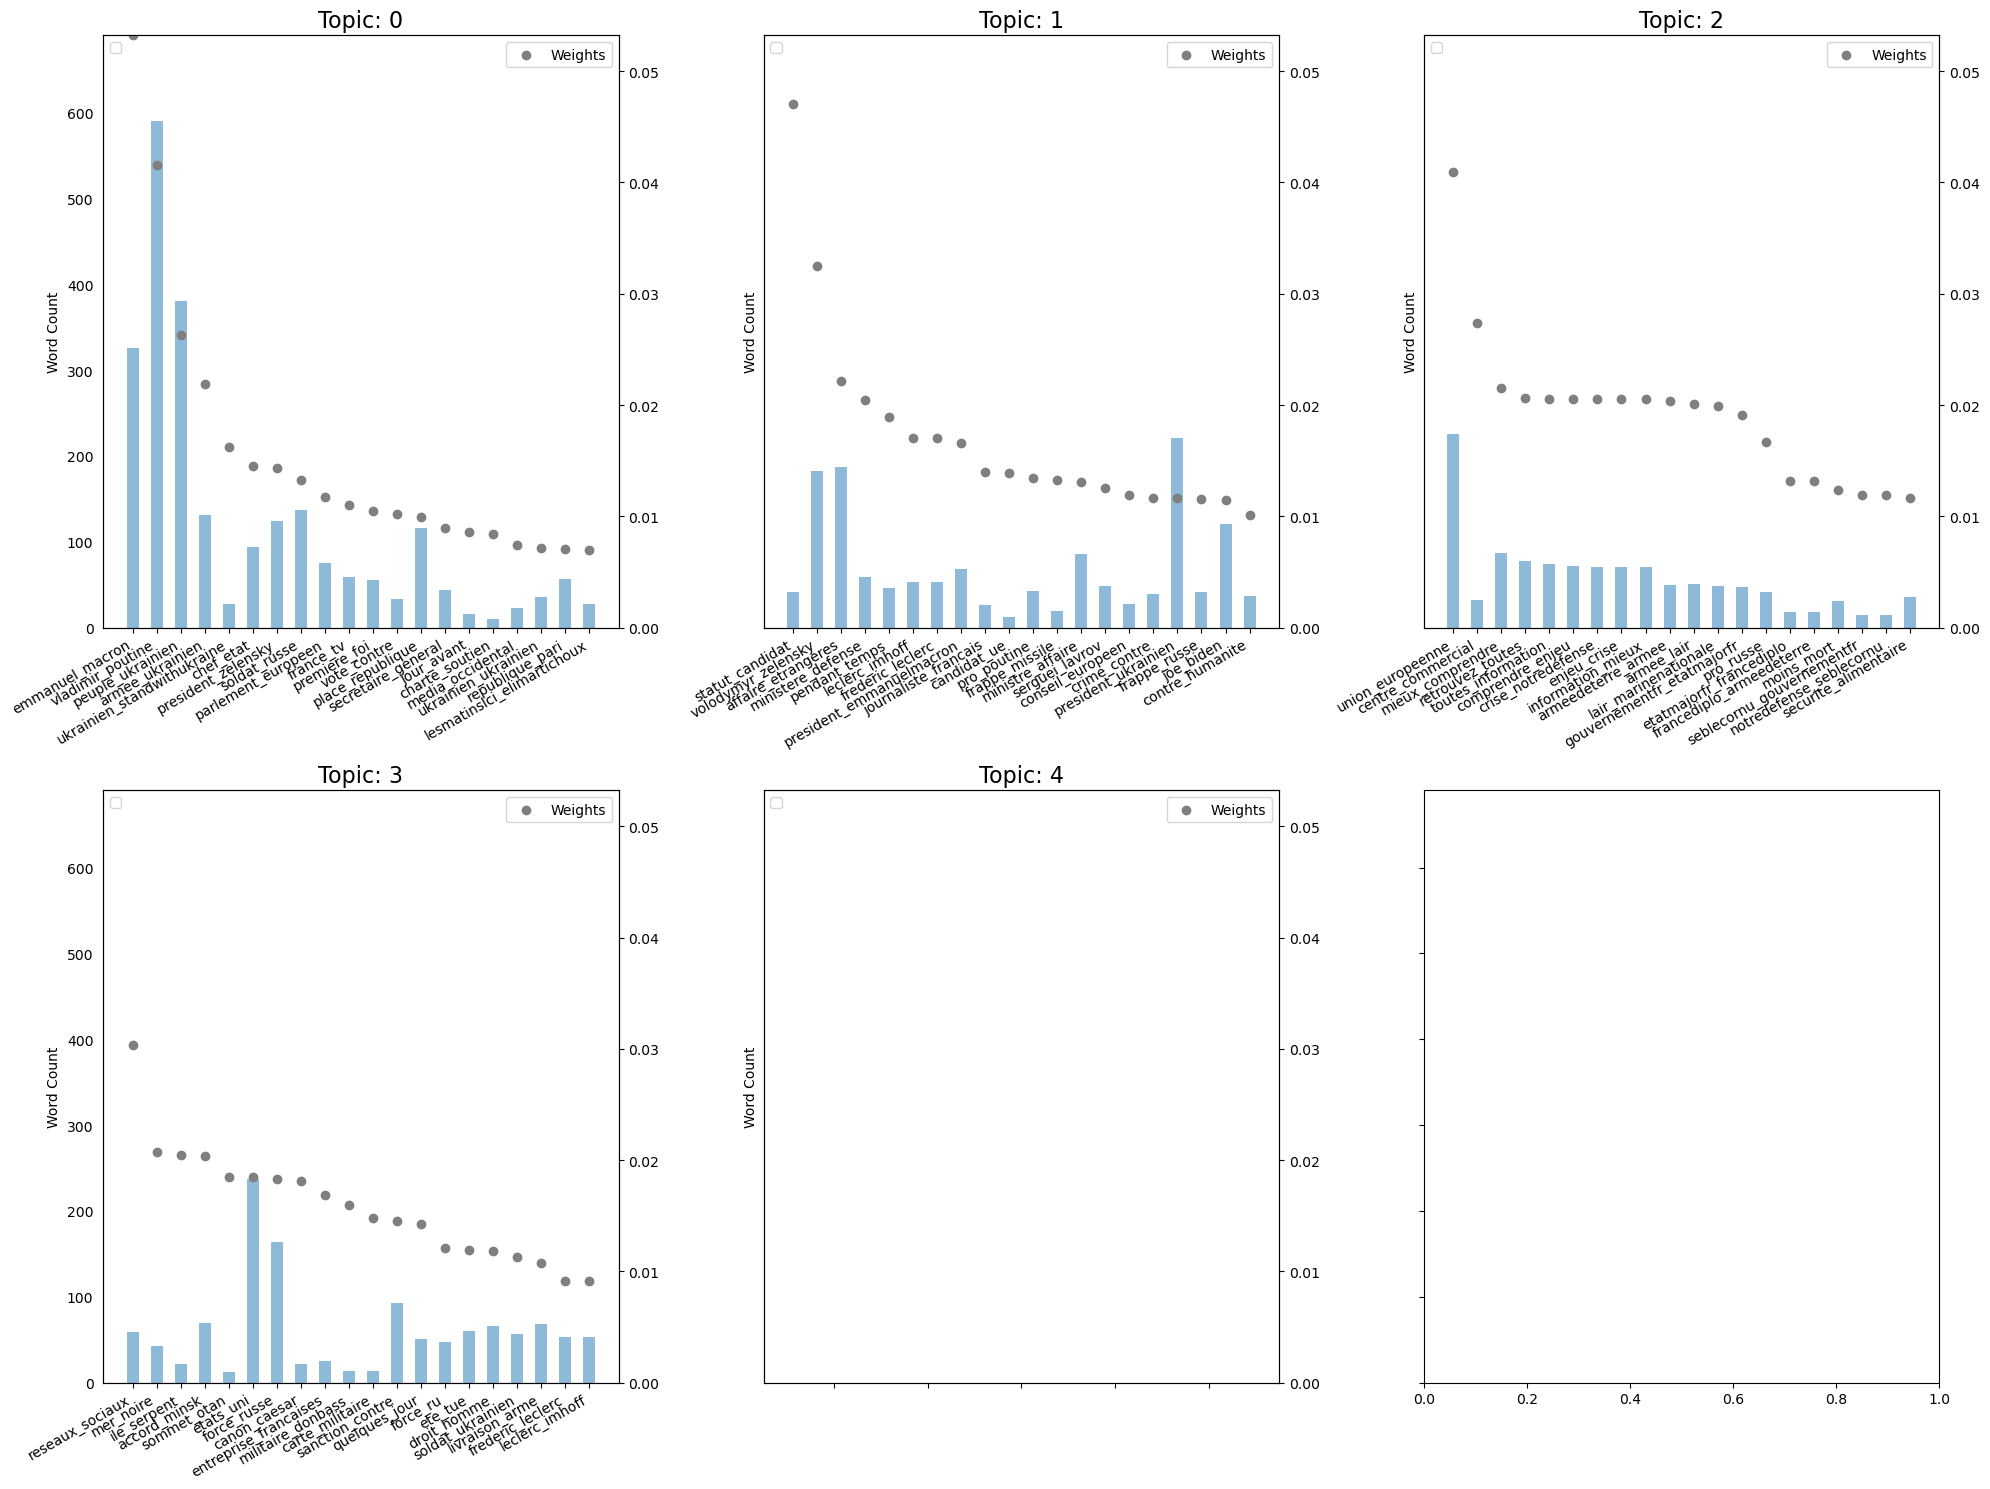

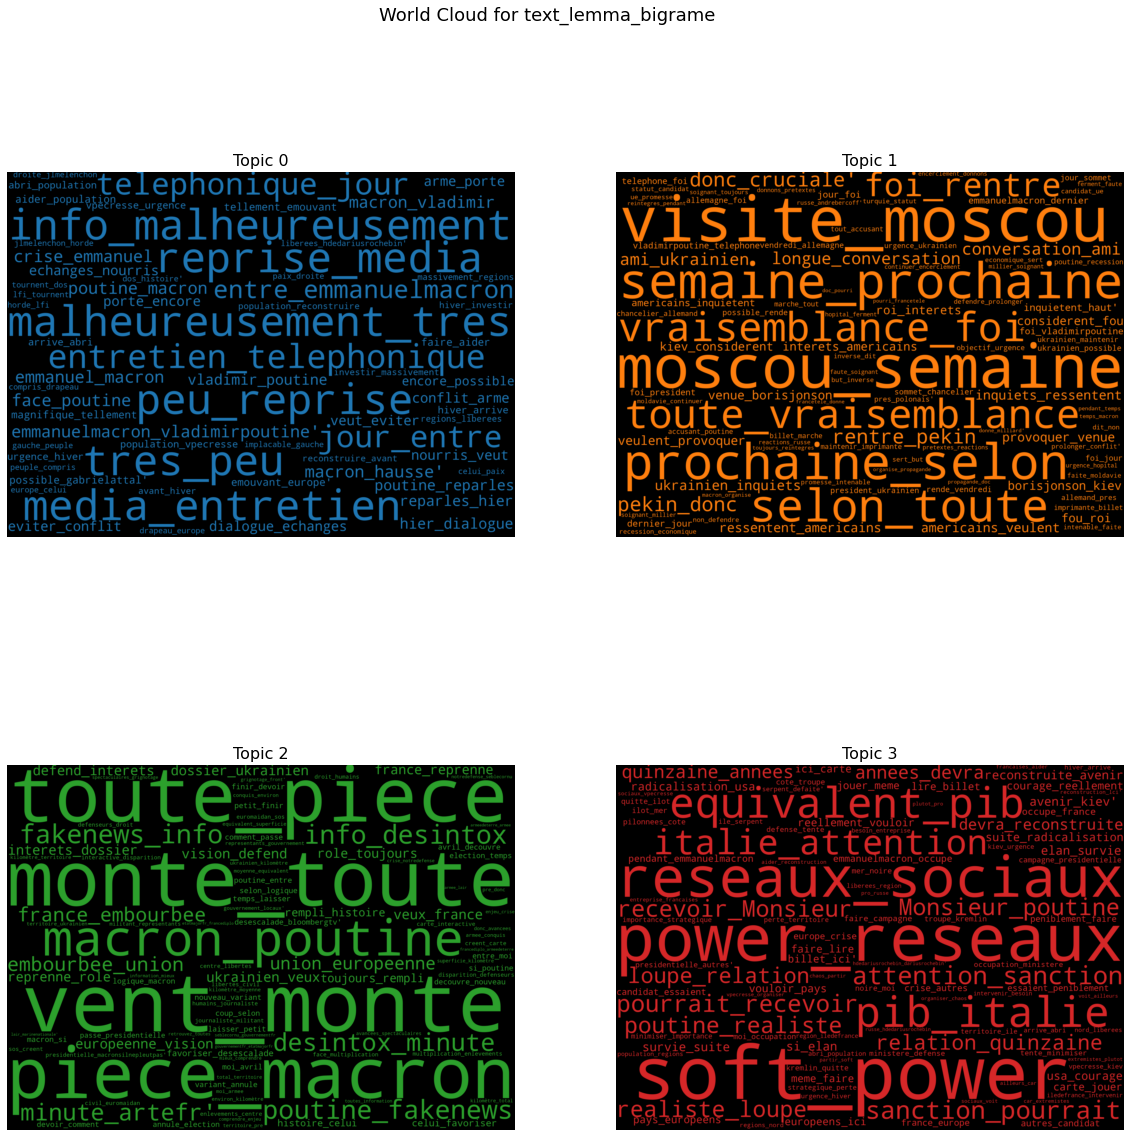

In [23]:
run_all(data.copy(deep=True), "text_lemma_bigrame", "lemma_bigrame", False, 4)

In [27]:
df_lemma_bigrame_4topics = pd.read_csv("~/PycharmProjects/twitter_text_mining/output/dominant_topics_lemma_bigrame_4topics.csv",
                              sep=";")

# lopinion_fr, faut_mettre, apres_avoir, reseaux_sociaux, suivez_direct, peut etre, peut dire, armees_gouv, doit être, chaque_jour, plus_plus, point_situation, depuis_debut

In [28]:
for i in df_lemma_bigrame_4topics["dominant_topic"].unique():
    display(df_lemma_bigrame_4topics[df_lemma_bigrame_4topics["dominant_topic"]==i].sort_values(by=["dominant_topic", "topic_perc_contrib"], ascending=[True, False]).head(50))

tweet_id  index  \
16892  1521420725785178112  16914   
6940   1498704887022039047   6948   
7572   1499085609478066190   7581   
13703  1506987733532782594  13724   
3517   1497268201087979526   3519   
13954  1507469298012327941  13975   
14313  1508743133391114244  14334   
9343   1500434648542896128   9355   
6170   1498387177750859776   6178   
7641   1499098909465001985   7650   
3452   1497241729224908811   3454   
4350   1497627367346515968   4355   
16409  1518243476231630848  16431   
18264  1531695351631167489  18287   
18304  1532020853843574785  18327   
2313   1496870617865359365   2314   
2400   1496898663137923081   2401   
6014   1498339118094426117   6022   
7566   1499088300052828167   7575   
17324  1524049525702373377  17346   
2014   1496814348882391042   2015   
12719  1504869492198936577  12739   
15998  1515332161724899334  16020   
16697  1520149174435684354  16719   
16675  1520036757068206080  16697   
4011   1497520793017802755   4016   
2587   1496928783659683846   2589   
4837   1497899359568019458   4844   
3888   1497495954127306754   3893   
3927   1497496740169199627   3932   
8384   1499666536327491586   8395   
8084   1499419591881207808   8095   
971    1495879238037262339    971   
7962   1499360038598623234   7973   
13662  1506937038779695107  13683   
942    1495851508952440839    942   
1237   1496166218729992196   1237   
6130   1498371593130631175   6138   
2187   1496841922228465667   2188   
8998   1500128091544465413   9010   
2353   1496878408638341125   2354   
2740   1496956016642174976   2742   
3430   1497233640484450304   3432   
4023   1497532142481510403   4028   
8392   1499678193271328774   8403   
8977   1500119857962135555   8989   
12677  1504788694921850892  12697   
13262  1506189741716385792  13283   
17465  1525115507204145153  17487   
18312  1532063383016845312  18335   

                                                                                                                                                                                                                                                                                                                                       text  \
16892                                                                                                                                                       🔴 entretien téléphonique entre emmanuel #macron et vladimir #poutine aujourd'hui à 12h annonce l'elysée. c'est la première fois depuis la réélection d'emmanuel macron #ukraine   
6940                             🇺🇦 solidarité envers le peuple d' #ukraine  \r\n@fabriceloher  et le conseil municipal de lorient convient la population à un rassemblement pour la paix et la solidarité envers le peuple ukrainien\r\n🗓 jeudi  3 mars à 18h30\r\n📍 sur le parvis de l’hôtel de ville de #lorient https://t.co/up9ykiaeko   
7572                                                                                      forte mobilisation devant l'hôtel de ville de @paris ce soir. \r\n\r\nsoutien au peuple ukrainien. paris, ville refuge, est à vos côtés et se mobilise pour l’#ukraine ⤵️\r\nhttps://t.co/n8j8htki5q\r\n\r\n@anne_hidalgo https://t.co/ohjo5qtzb8   
13703                       le secrétaire général de l'otan : "toute utilisation d'armes chimiques [en #ukraine] changerait la nature du conflit et aurait des conséquences très graves, [...] sur la population ukrainienne mais aussi sur les pays de l'otan car des composants chimiques peuvent s'y retrouver." https://t.co/gl0upkn2sy   
3517         alors que l'agression de #poutine contre l'#ukraine tue &amp; que le peuple résiste avec bravoure à kiev &amp; ailleurs, rdv samedi à 15h, place de la république à paris.\r\npour dire notre soutien aux ukrainiens et notre indignation devant l'agression en cours.\r\n#standwithukraine #stopputin https://t.co/xbzrxgqpgt   
13954                                                                                                                   

tweet_id  index  \
15997  1515325232898265088  16019   
14971  1511029618718957568  14992   
15914  1514842860398551040  15936   
15934  1514949800084619265  15956   
16537  1519192171710193665  16559   
16765  1520650539318525952  16787   
18889  1537387819261382656  18913   
15445  1512415756960608258  15467   
15947  1515005126511149060  15969   
19412  1540961454555275265  19436   
16024  1515566827530862592  16046   
17095  1522828055143665664  17117   
14926  1510922660213055488  14947   
17972  1529553857029840899  17995   
15041  1511239516048310272  15062   
14671  1510161553349398532  14692   
9359   1500443992105881600   9371   
9552   1500574759628812291   9565   
9850   1500883613688250369   9863   
10113  1501215883133399043  10126   
10458  1501579682852093954  10474   
10806  1501952361362702343  10823   
11099  1502347419601838082  11117   
11560  1503043471963209741  11580   
11813  1503417516093329414  11833   
12130  1503808908611227650  12150   
12317  1504128044902006788  12337   
12567  1504504634320338945  12587   
12710  1504861575890485256  12730   
13098  1505829340101152768  13119   
13155  1505917384548397062  13176   
13318  1506277585680015361  13339   
13749  1507040679490424838  13770   
13890  1507376614602153988  13911   
14242  1508440792678944775  14263   
14344  1508809826423517185  14365   
15712  1513838445852037122  15734   
9661   1500758836034129923   9674   
9756   1500821167510278144   9769   
12293  1504110677404835846  12313   
12314  1504128567508336642  12334   
12385  1504171772047941634  12405   
7008   1498728633560702981   7016   
8399   1499671800036438016   8410   
12319  1504127210491465731  12339   
12324  1504135274309328898  12344   
8541   1499739978074632196   8552   
4694   1497855261490429955   4701   
9848   1500883660517658629   9861   
11840  1503438690206552067  11860   

                                                                                                                                                                                                                                                                                                                                         text  \
15997                        si avec ça t'as rien compris, c'est qu't'es vraiment un abruti !\r\n#medias #france #rothschildgate \r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/xicflqu8vc   
14971                               👇😂👍certains aiment #macrn à la folie.\r\nça les #medias en #france ne vous en parleront pas !\r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/mrtimcmoou   
15914                      👇🧐tout est devant nos yeux il suffit de les ouvrir !\r\n#medias #france #rothschildgate #macrondegage \r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/ey9cvidvbr   
15934                      👇🧐tout est devant nos yeux il suffit de les ouvrir !\r\n#medias #france #rothschildgate #macrondegage \r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/zsetdnnpr7   
16537                                                                    1/2 ça les #medias en #france ne vous en parleront pas !\r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/lo1mz6qgpy   
16765                                                                    1/2 ça les #medias en #france ne vo

tweet_id  index  \
7945   1499339381064273920   7954   
18546  1534465537878724608  18569   
1848   1496785863228813312   1849   
1880   1496782704267784194   1881   
6599   1498628149546037251   6607   
5145   1497976305073152005   5152   
6768   1498659914339733508   6776   
14466  1509229226922233859  14487   
8252   1499547971930800130   8263   
13999  1507659305113337858  14020   
15633  1513383487138578432  15655   
10724  1501881526379810816  10741   
7906   1499328810226962435   7915   
9529   1500559496468381698   9542   
9533   1500557615780216834   9546   
14434  1509140147736043525  14455   
12030  1503737886113415174  12050   
14933  1510928844441718786  14954   
6417   1498561530664730626   6425   
8292   1499620813510742016   8303   
6192   1498382079167725568   6200   
4462   1497667879344521222   4469   
7995   1499373942506758151   8006   
4357   1497639799150284801   4362   
18209  1531349349078388737  18232   
2966   1497112400100745225   2968   
595    1494987374354485250    595   
13981  1507639477077958666  14002   
18174  1531284841190281216  18197   
18202  1531320719568674817  18225   
17615  1526090557063319552  17637   
1454   1496560495658082304   1454   
752    1495462164458524673    752   
1809   1496764589668978697   1810   
3819   1497460862734450689   3824   
7315   1498954500723331072   7324   
12476  1504386463168925696  12496   
15267  1511878629256531968  15288   
16469  1518858521793736704  16491   
16885  1521385862612848640  16907   
18101  1530878130960973824  18124   
18205  1531336890925957122  18228   
18548  1534460593775820800  18571   
414    1493307432298291206    414   
16218  1516868308938723335  16240   
16335  1517795883768815616  16357   
5854   1498278717851934728   5862   
10050  1501146115550363648  10063   
16468  1518860311222226945  16490   
15693  1513750245963976704  15715   

                                                                                                                                                                                                                                                                                                                                     text  \
7945                            🇫🇷🇷🇺☣️😨"ce n'est pas nous qui commençons à parler de guerre nucléaire, c'est votre ministre jean-yves le drian", accuse le ministre russe des affaires étrangères sergueï lavrov, interrogé par @dariusrochebin, en direct, sur #lci @tf1info #ukrainerussiawar #ukraine #poutine https://t.co/vomduckc6g   
18546                    🔴🇷🇺 "si l'#ukraine est prête à lancer des opérations de déminages, nous sommes prêts également", a déclaré le ministre russe des affaires étrangères sergueï #lavrov. \r\n\r\nil pointe du doigt la décision du président ukrainien volodymyr #zelensky de "s'opposer à [ces] efforts" ⤵ https://t.co/3qdfzhb1wk   
1848                                                                                                                 🚨🇺🇦🇷🇺 flash | le président ukrainien #zelensky annonce qu’il retirera les sanctions de tous les citoyens ukrainiens qui sont prêts à prendre les armes pour défendre l’#ukraine.\r\n\r\n(déclaration) #ukrainerussie   
1880                                                                                                                 🚨🇺🇦🇷🇺 flash | le président ukrainien #zelensky annonce qu’il retirera les sanctions de tous les citoyens ukrainiens qui sont prêts à prendre les armes pour défendre l’#ukraine.\r\n\r\n(déclaration) #ukrainerussie   
6599                                         kharkiv a été bombardée par les russes, le président ukrainien volodymyr zelensky dénonce "un crime de guerre"\r\n\r\nsuivez en direct la situation 👉 https://t.co/nty9xf51kn\r\n\r\n#kharkiv #russie #ukraine #poutine #russia #ukraineunderattack #ukraineinvasion https://t.co/pyzbxfvp8p   
5145                                                                                  l'#ukraine veut "essayer" de négocier avec la 

tweet_id  index  \
15609  1513137392588361746  15631   
15666  1513529143685795843  15688   
15779  1514240024811905027  15801   
15865  1514582503650213888  15887   
16003  1515370469674958864  16025   
16046  1515748331099770881  16068   
16088  1516102618535366659  16110   
16149  1516404097100001281  16171   
16268  1517156592327688192  16290   
16309  1517497051063496704  16331   
16370  1517921501030322176  16392   
16435  1518569662602256386  16457   
16490  1518933217373564931  16512   
16572  1519367842013093888  16594   
16605  1519648583263428608  16627   
16676  1520044173210144769  16698   
16743  1520411341919559680  16765   
16807  1520819033746161665  16829   
16911  1521510114376695809  16933   
16950  1521789817926868994  16972   
17075  1522601697587220480  17097   
17116  1522940274208509953  17138   
17162  1523249170936905733  17184   
17246  1523663029266968576  17268   
17297  1523958986449592321  17319   
17373  1524414482361077760  17395   
17418  1524760374964363265  17440   
17464  1525108443077562368  17486   
17815  1527972948358873093  17837   
17849  1528396937698979841  17872   
17881  1528737934676873217  17904   
17921  1529071104589012992  17944   
17954  1529451688796504065  17977   
18233  1531534511867060227  18256   
18301  1531981941557297153  18324   
18377  1532692553010663426  18400   
18499  1533893605496180736  18522   
18628  1535250988638126083  18652   
19057  1537816592263700487  19081   
19182  1538907598208086016  19206   
19541  1541710903531413504  19565   
19606  1542149344056545280  19630   
19696  1542842180091478016  19720   
17636  1526205272099799042  17658   
17665  1526555878475849732  17687   
17792  1527644011086983170  17814   
17573  1525808371995115521  17595   
17508  1525434614159970304  17530   
17744  1527268278921478145  17766   
11795  1503405038785421314  11815   

                                                                                                                                                                                                                                                                                                                            text  \
15609                          📍point de situation en #ukraine au 10/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense \r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
15666                         📍point de situation en #ukraine au 11/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise ⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense \r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
15779                            📍point de situation en #ukraine au 13/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense\r\n@florence_parly @hervegrandjean @gouvernementfr @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
15865                          📍point de situation en #ukraine au 14/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense \r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
16003                         📍point de situation en #ukraine au 16/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise. ⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense\r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
16046                         📍point de situation en #ukraine au 17/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise ⤵️\r\nhttps://t.co/pxnd7

In [43]:
sort_df_lemma_bigrame_4topics = df_lemma_bigrame_4topics.sort_values(by=["dominant_topic", "topic_perc_contrib"], ascending=[True, False])
sort_df_lemma_bigrame_4topics["seq"] = sort_df_lemma_bigrame_4topics.groupby(["dominant_topic"]).cumcount() + 1
sort_df_lemma_bigrame_4topics = sort_df_lemma_bigrame_4topics[sort_df_lemma_bigrame_4topics["seq"] <= 50]
_users = sort_df_lemma_bigrame_4topics.groupby(["dominant_topic", "username"])["tweet_id"].nunique()
_users = _users.reset_index()

In [44]:
sort_df_lemma_bigrame_4topics.head()

tweet_id  index  \
10737  1501883327816552450  10749   
5473   1498098464739184644   5479   
14320  1508743133391114244  14336   
9344   1500434648542896128   9354   
4160   1497557158673756167   4163   

                                                                                                                                                                                                                                                                                    text  \
10737                                                              🔴 emmanuel #macron et le chancelier allemand olaf #scholz se sont entretenus ce matin avec vladimir #poutine pour « exiger de la russie qu’elle cesse immédiatement le feu » en #ukraine annonce l’elysée @franceinfo   
5473   [ 🇺🇦#ukraine / 🇷🇺#russie ]\r\n\r\nla corée du nord affirme que les états-unis sont responsables de la guerre en ukraine. elle dénonce un "deux poids, deux mesures" des états-unis à l'égard du reste du monde \r\n\r\n#ukrainerussiawar #vladimirpoutine https://t.co/9t5cn9uzub   
14320                                                                                                                                                         🔴 appel téléphonique entre emmanuel #macron et vladimir #poutine aujourd'hui à 16h30 annonce l'élysée #ukraine @franceinfo   
9344                                                                                                                                                                   🔴 l’entretien téléphonique entre emmanuel #macron et vladimir #poutine vient de débuter annonce l’élysée #ukraine   
4160                             les etats-unis vont fournir une nouvelle aide militaire à l'#ukraine, d'un montant de 350 millions de dollars, pour aider #kiev à combattre l'invasion russe, a annoncé le chef de la diplomatie américaine antony blinken #afp https://t.co/yo8saaeqm9   

             username  \
10737  GuillaumeDaret   
5473    Le_Millenaire   
14320  GuillaumeDaret   
9344   GuillaumeDaret   
4160            afpfr   

                                                                                                                                                                                                                                                                                              text_lemma_bigrame  \
10737                                            emmanuel_macron macron_chancelier chancelier_allemand allemand_olaf olaf_scholz scholz_entretenu entretenu_matin matin_vladimir vladimir_poutine poutine_exiger exiger_cesse cesse_immediatement immediatement_feu feu_annonce annonce_elysee elysee_franceinfo   
5473                                                         coree_nord nord_affirme affirme_etats etats_uni uni_responsable responsable_denonce denonce_deux deux_poids poids_deux deux_mesure mesure_etats etats_uni uni_egard egard_reste reste_monde monde_ukrainerussiawar ukrainerussiawar_vladimirpoutine   
14320                                                                                                                                                     appel_telephonique telephonique_entre entre_emmanuel emmanuel_macron macron_vladimir vladimir_poutine poutine_annonce annonce_elysee elysee_franceinfo   
9344                                                                                                                                        entretien_telephonique telephonique_entre entre_emmanuel emmanuel_macron macron_vladimir vladimir_poutine poutine_vient vient_debuter debuter_annonce annonce_elysee   
4160   etats_uni uni_vont vont_fournir fournir_nouvelle nouvelle_aide aide_militaire militaire_montant montant_million million_dollar dollar_aider aider_kiev kiev_combattre combattre_invasion invasion_annonce annonce_chef chef_diplomatie diplomatie_americaine americaine_antony antony_blinken blinken_afp   

       document_no  dominant_topic  topic_perc_contrib  \
10737        10737              

In [45]:
_users = df_lemma_bigrame_4topics.groupby(["dominant_topic", "username"])["tweet_id"].nunique()
_users = _users.reset_index()
_users = _users.sort_values(by=["dominant_topic", "tweet_id"], ascending=[True, False])
_users["seq"] = _users.groupby(["dominant_topic"]).cumcount() + 1
_users = _users[_users["seq"]<=20]
#_users.drop_duplicates("dominant_topic")

In [46]:
import plotly.express as px

fig = px.bar(_users, x="dominant_topic", y="tweet_id", color="username", title="top 20 contributions to the topics")
fig.show()

## Lemma trigrame 

In [ ]:
run_all(data.copy(deep=True), "text_lemma_trigrame", "lemma_trigrame", True)

## Stem 

In [12]:
df_stem_2topics = pd.read_csv("~/PycharmProjects/twitter_text_mining/output/dominant_topics_stem_2topics.csv",
                              sep=";")

In [16]:
for i in df_stem_2topics["dominant_topic"].unique():
    display(df_stem_2topics[df_stem_2topics["dominant_topic"]==i].sort_values(by=["dominant_topic", "topic_perc_contrib"], ascending=[True, False]).head(25))

tweet_id  index  \
15465  1512415756960608258  15467   
15934  1514842860398551040  15936   
15954  1514949800084619265  15956   
16017  1515325232898265088  16019   
7701   1499126686331424785   7701   
17053  1522265289509031938  17055   
482    1493981200964145155    482   
16044  1515566827530862592  16046   
18418  1532817805636149248  18420   
1467   1496601631982501889   1467   
19292  1539851992155176960  19294   
14390  1508867076093624322  14392   
12594  1504523626560868353  12596   
13093  1505801594012676098  13095   
14780  1510546332611747852  14782   
18617  1534855888053456896  18619   
1702   1496754358934978560   1702   
18824  1537030140131266560  18826   
7624   1499103056029528069   7624   
6505   1498587751561801728   6505   
7056   1498747791673380864   7056   
7672   1499106577831366656   7672   
11884  1503461147852345361  11886   
13783  1507055858013900806  13785   
781    1495656460327526401    781   

                                                                                                                                                                                                                                                                                                                             text  \
15465                               👇🧐on n'est jamais si bien servi que par soi-même !\r\n#france #medias #touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine #rotschildgate https://t.co/ohkccjthoe   
15934          👇🧐tout est devant nos yeux il suffit de les ouvrir !\r\n#medias #france #rothschildgate #macrondegage \r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/ey9cvidvbr   
15954          👇🧐tout est devant nos yeux il suffit de les ouvrir !\r\n#medias #france #rothschildgate #macrondegage \r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/zsetdnnpr7   
16017            si avec ça t'as rien compris, c'est qu't'es vraiment un abruti !\r\n#medias #france #rothschildgate \r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/xicflqu8vc   
7701                      face à la crise, face à cette crise - plus encore que tout autre historique - l’exigence de lucidité, l’exigence de solidarité et l’exigence de responsabilité. et la volonté sans cesse réaffirmée de ne jamais céder à la facilité des temps ni de céder tout court. #ukraine https://t.co/0vydi1dp4a   
17053      j'ai du mal à comprendre : @faureolivier @rglucks1 le #ps et @eelv appellent à voter pour @jlmelenchon à matignon, sachant que sa 1ère décision sera de suspendre toute aide à l'#ukraine et de réclamer sa capitulation aux conditions de poutine.\r\n\r\nvous n'avez vraiment aucune honte ? https://t.co/fvfrontelt   
482            l'#ue devra opposer une réponse forte en cas d'agression contre l'#ukraine. mais à l'évidence l'adhésion de ce pays à l'#otan serait un facteur de guerre. seuls la négociation et le respect des accords de minsk nous sortiront de l'impasse actuelle.\r\n👉 mon intervention en plénière https://t.co/ywvav3merc   
16044      1/2 #macron l'a dit "il y aura une augmentation des prix du carburant et pénurie alimentaire!\r\n#medias #france #rothschildgate \r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/jbmnphuv5y   
18418           @el_dic_tator @yvespdb #ukraine obtient 17milliard€💰 de #france &amp; allemagne, mais n'applique pas \r\n🕊️les acc

tweet_id  index  \
15217  1511666698948169734  15219   
15276  1511802812983922691  15278   
11636  1503083474466521092  11638   
19647  1542391313785577474  19649   
11597  1503053273451827201  11599   
9560   1500575338887274506   9561   
9563   1500574931460968450   9564   
18426  1532980023799517184  18428   
9570   1500571435785404417   9571   
11753  1503327065222832129  11755   
18421  1532926133255254016  18423   
7270   1498933424274518018   7270   
18208  1531301007744983041  18210   
14725  1510249194556215305  14727   
19633  1542193699009986563  19635   
9966   1500963592711155715   9967   
15445  1512371806459641860  15447   
13410  1506534334643290112  13412   
10970  1502220555008843781  10972   
11317  1502664933233897478  11319   
15039  1511153618434600961  15041   
12968  1505494355351687172  12970   
11554  1503009384238100484  11556   
15291  1511932400363782144  15293   
9274   1500394542167732227   9275   

                                                                                                                                                                                                                                                                                                                         text  \
15217           avec @stef_guillemot et @ivlevyorke, nous nous sommes rendus à 50km au nord-ouest de #kiev ! à #borodyanka, les frappes russes ont éventré un immeuble de 9 étages. et les chars tiraient "à vue" selon les témoins. au moins 300 civils ont péri selon le maire de la ville #ukraine https://t.co/g167vrcdyx   
15276           avec @stef_guillemot et @ivlevyorke, nous nous sommes rendus à 50km au nord-ouest de #kiev ! à #borodyanka, les frappes russes ont éventré un immeuble de 9 étages. et les chars tiraient "à vue" selon les témoins. au moins 300 civils ont péri selon le maire de la ville #ukraine https://t.co/rukybdhmae   
11636             [a la une a 20h]  \r\n#ukraine : de nouvelles frappes russes ont visé une base militaire près de la frontière polonaise, faisant au moins 35 morts selon les autorités locales, tandis que près de kiev, un journaliste américain a été tué et un autre blessé par balles  #afp 1/5 https://t.co/iyxn4wgulq   
19647                #ukraine 30/06 depuis plusieurs jours, l’armée rus lance ses missiles sur les villes.\r\nici le 28/06 à mykolaiv ce kh-22 (1 t de charge explosive) percute un immeuble d’habitation où dormaient des civils.\r\nparmi 3 morts, ève, une jeune fille de 6 ans tuée dans son lit. https://t.co/mhlotlmlqi   
11597        [a la une a 18h]  \r\n#ukraine : de nouvelles frappes russes ont visé dans la nuit une base militaire près de la frontière polonaise, faisant au moins 35 morts selon les autorités locales, tandis que près de kiev, un journaliste américain a été tué par balle #afp #afpgraphics 1/5 https://t.co/jiqtduz0y0   
9560                                                  sur le front nord : \r\n\r\n7. kiev : l’encerclement de la ville se poursuit. les combats continuent pour le contrôle de la zone nord-ouest de l’oblast de kiev. la ligne de contact se situe désormais à une vingtaine de kilomètres au nord de kiev. \r\n\r\n#ukraine   
9563                         sur le front est : zone de progression des forces russes\r\n \r\n1. donbass : les forces séparatistes ont réussi une percée dans le nord du donbass.\r\n\r\n2. kharkiv : les bombardements montent en intensité. l’encerclement de la ville est en cours par les forces russes. \r\n\r\n#ukraine   
18426  #ukraine 04/06 autre chiffre effrayant : en 100 jours, les forces rus ont bombardé 169 hôpitaux et attaqué 33 centres de soin identifiés.\r\nce sont des crimes de guerre.\r\net les symptômes d’une méthode de guerre russe aveugle et cherchant à terroriser déjà vue en syrie tchétchènie.. https://t.co/zs9tnzl3bf   
9570                 terrible photo, qui me hante depuis que je l’ai vue (attention, elle est violente). a irpin, près du pont détruit, une famille tentait de fuir ki

===== Method : stem =====
... Running bag of words
... Running search for best nb of topics
=== LDA model with 2 topics took : 1.1 minutes
Topic: 0 -> Words: 0.021*"ukrainien" + 0.018*"arme" + 0.014*"russ" + 0.013*"ete" + 0.011*"kiev" + 0.008*"civil" + 0.007*"an" + 0.007*"donbass" + 0.007*"crim" + 0.007*"mort"
Topic: 1 -> Words: 0.018*"franc" + 0.013*"macron" + 0.013*"poutin" + 0.009*"tout" + 0.009*"europ" + 0.009*"europeen" + 0.009*"contr" + 0.009*"ue" + 0.008*"zelensky" + 0.007*"president"
=== Coherence Score: 0.32
=== LDA model with 3 topics took : 0.87 minutes
Topic: 0 -> Words: 0.017*"pay" + 0.010*"aid" + 0.009*"mem" + 0.009*"mond" + 0.009*"san" + 0.009*"journal" + 0.008*"grand" + 0.008*"auss" + 0.007*"frapp" + 0.007*"tre"
Topic: 1 -> Words: 0.026*"macron" + 0.026*"poutin" + 0.015*"zelensky" + 0.014*"president" + 0.010*"militair" + 0.010*"fair" + 0.010*"parl" + 0.010*"emmanuelmacron" + 0.009*"si" + 0.009*"an"
Topic: 2 -> Words: 0.026*"ukrainien" + 0.023*"franc" + 0.020*"arme" + 0.

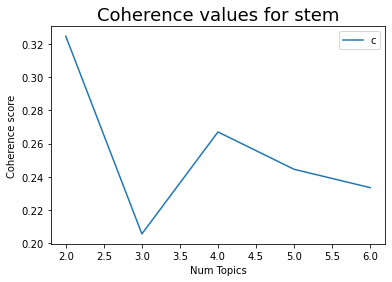

... Running lda with 2 topics
=== LDA model with 2 topics took : 1.0 minutes
Topic: 0 -> Words: 0.021*"ukrainien" + 0.018*"arme" + 0.014*"russ" + 0.013*"ete" + 0.011*"kiev" + 0.008*"civil" + 0.007*"an" + 0.007*"donbass" + 0.007*"crim" + 0.007*"mort"
Topic: 1 -> Words: 0.018*"franc" + 0.013*"macron" + 0.013*"poutin" + 0.009*"tout" + 0.009*"europ" + 0.009*"europeen" + 0.009*"contr" + 0.009*"ue" + 0.008*"zelensky" + 0.007*"president"
=== Coherence Score: 0.32
... Running lda visualization
... Running dominant topics
Format topics took 8.9 minutes
... Graph topics and keywords


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


... Graph word cloud for each topic

 Total running time: 16.881464715798696 minutes


index  \
tweet_id                     
1488433061196812291      0   
1488447673883676672      1   
1488493240475078658      2   
1488502446771081216      3   
1488511509961527302      4   
...                    ...   
1542967067611127813  19732   
1542963887175335937  19733   
1542971236459888641  19734   
1542969041161158656  19735   
1542981780092985344  19736   

                                                                                                                                                                                                                                                                                                                                        text  \
tweet_id                                                                                                                                                                                                                                                                                                                                       
1488433061196812291                                                                                                                               voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc   
1488447673883676672                                                                                                                                                                                                                                               #ukraine face à poutine ... macron hausse le ton ! https://t.co/mfpsevidlv   
1488493240475078658                                                                          crise en #ukraine : « emmanuel #macron et vladimir #poutine, se sont reparlés hier soir. il y a un dialogue et des échanges nourris. on veut éviter un conflit armé à nos portes. c'est encore possible » @gabrielattal https://t.co/v7ovwb9n4i   
1488502446771081216                           la #russie c'est l'équivalent du pib de l'italie. attention aux sanctions qu'elle pourrait recevoir et monsieur poutine est réaliste. on a loupé la relation avec la russie il y a une quinzaine d'années : elle devra être reconstruite dans l'avenir. #kiev #ukraine https://t.co/b15g66ehvl   
1488511509961527302                                                                                                                                                      crise en #ukraine : voilà pourquoi il faut sortir du piège atlantiste, refuser la guerre et quitter l’otan sur le champ ! nouvelle vidéo ➡️ https://t.co/qjyacvg9pk   
...                                                                                                                                                                                                                                                                                                                                      ...   
1542967067611127813                                                                                                                                                                                                                                    c'est magnifique et tellement émouvant 🥰🇺🇦🇪🇺 #ukraine #europe https://t.co/0ywt0zwqot   
1542963887175335937  👉 guerre un #ukraine : que faire pour aider les populations ?\r\n\r\n🗣️ @vpecresse \r\n"il y a urgence : l'hiver qui arrive. il faut mettre à l'abri les populations, reconstruire avant l'hiver [...] il faut investir massivement dans les régions libérées."\r\n\r\n📺 #le20hdedariusrochebin https://t.co/rh8jkshhcs   
1542971236459888641          👉 guerre en #ukraine : le soft power des réseaux sociaux\r\n\r\n🗣️ @vpecresse\r\n\r\n"on peut organiser le chaos à partir de ce soft power des réseaux sociaux [...] on le voit d'ailleurs car nos extrémistes sont plutôt pro russes."\r\n\r\n📺 

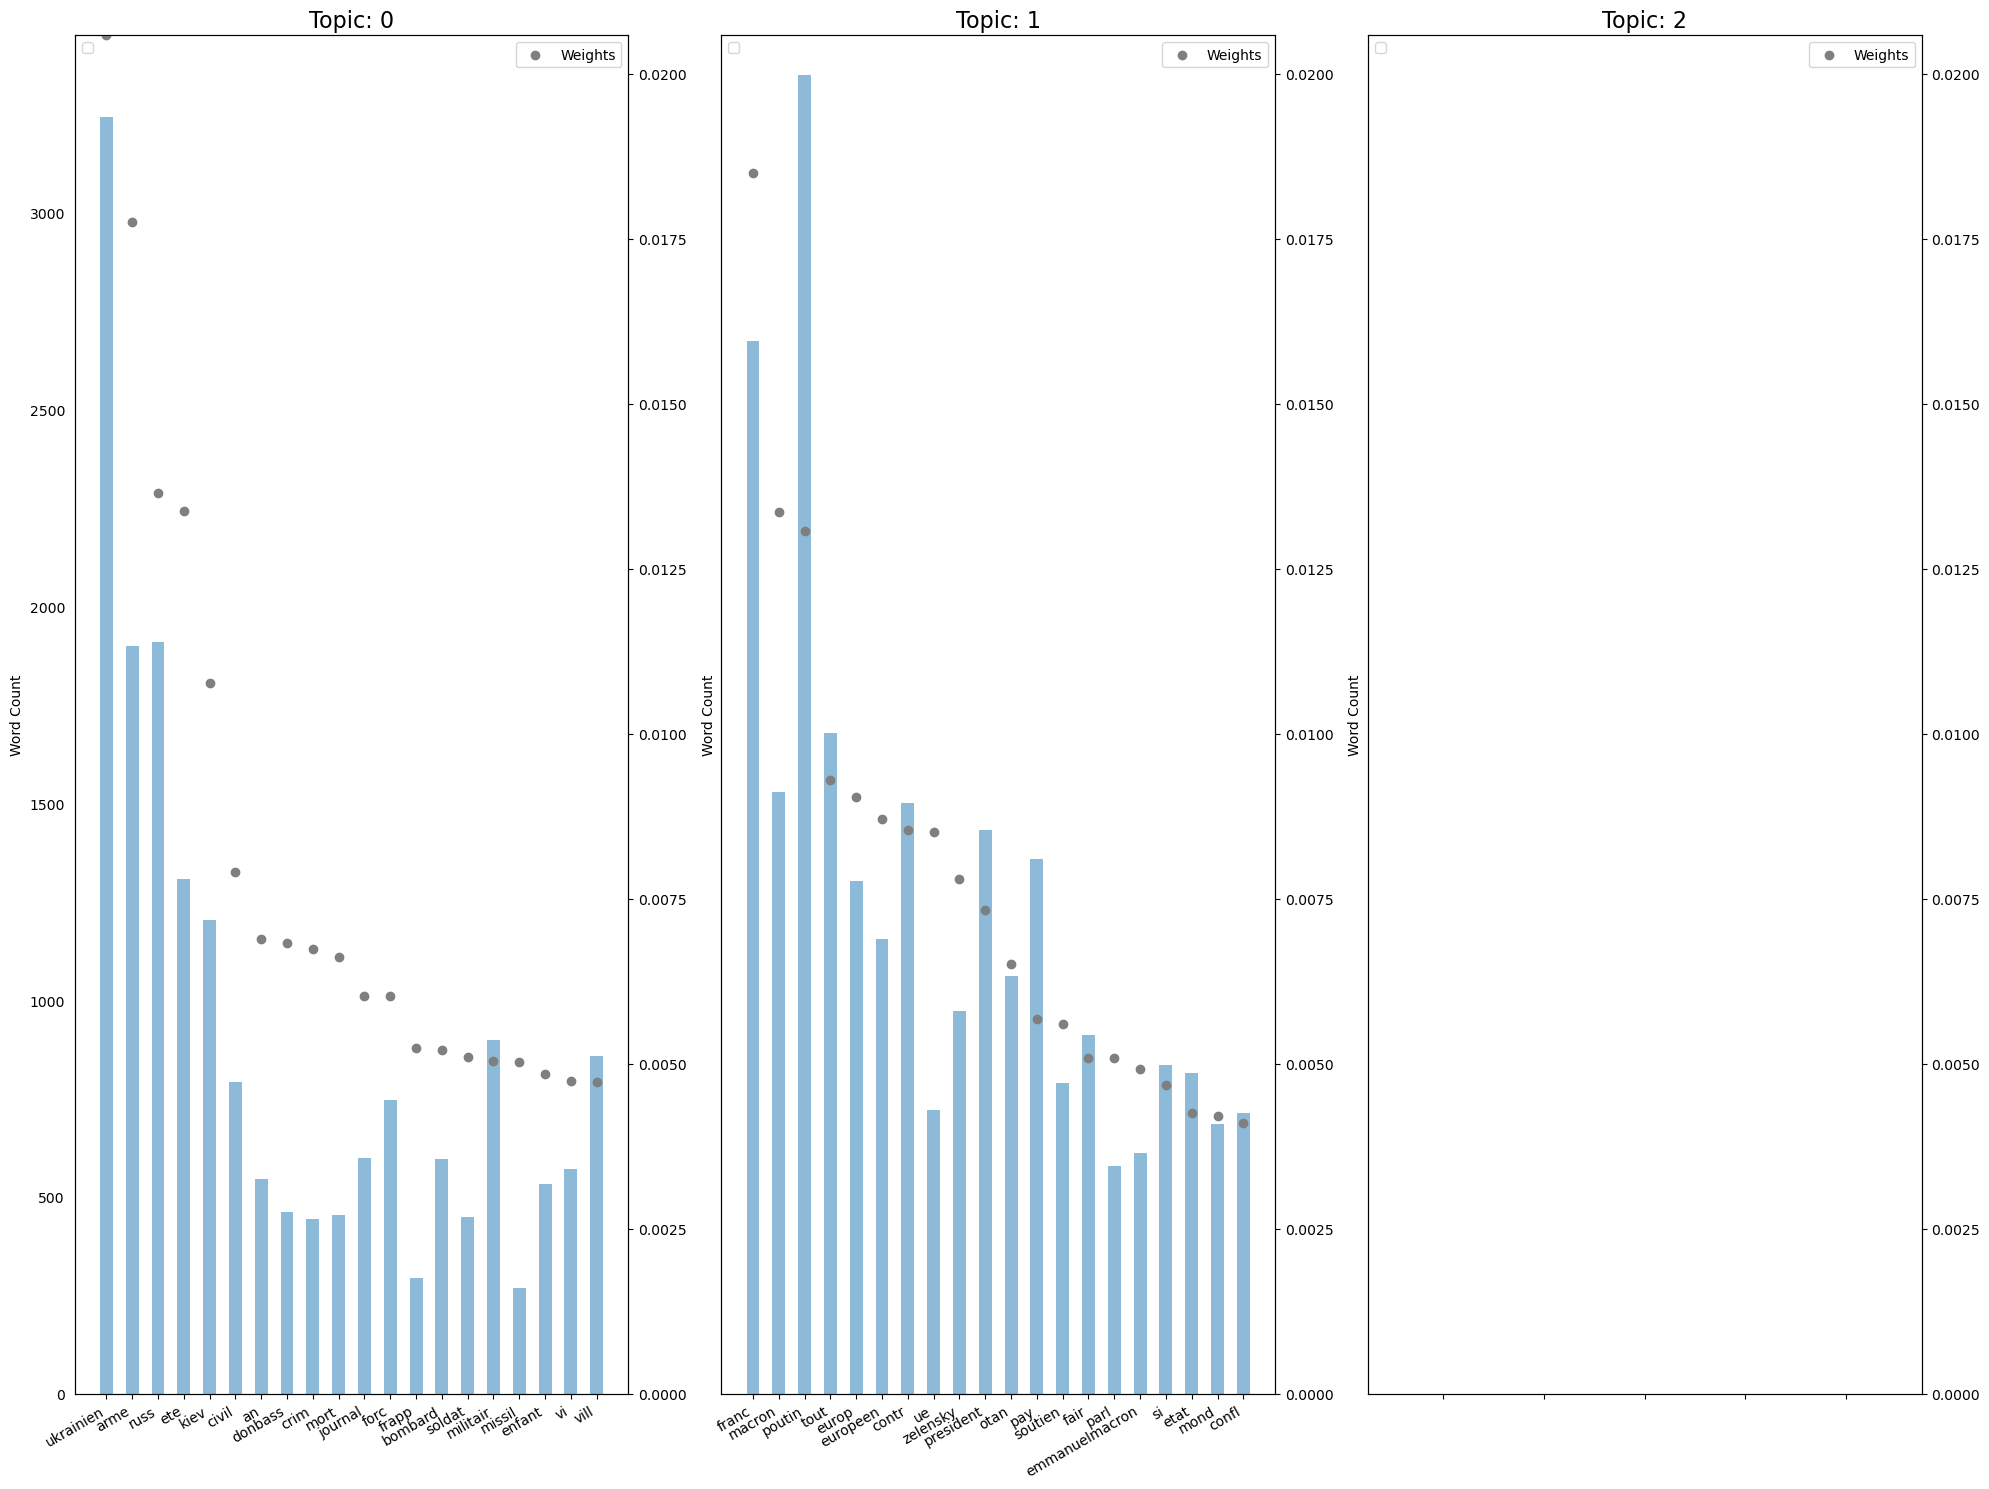

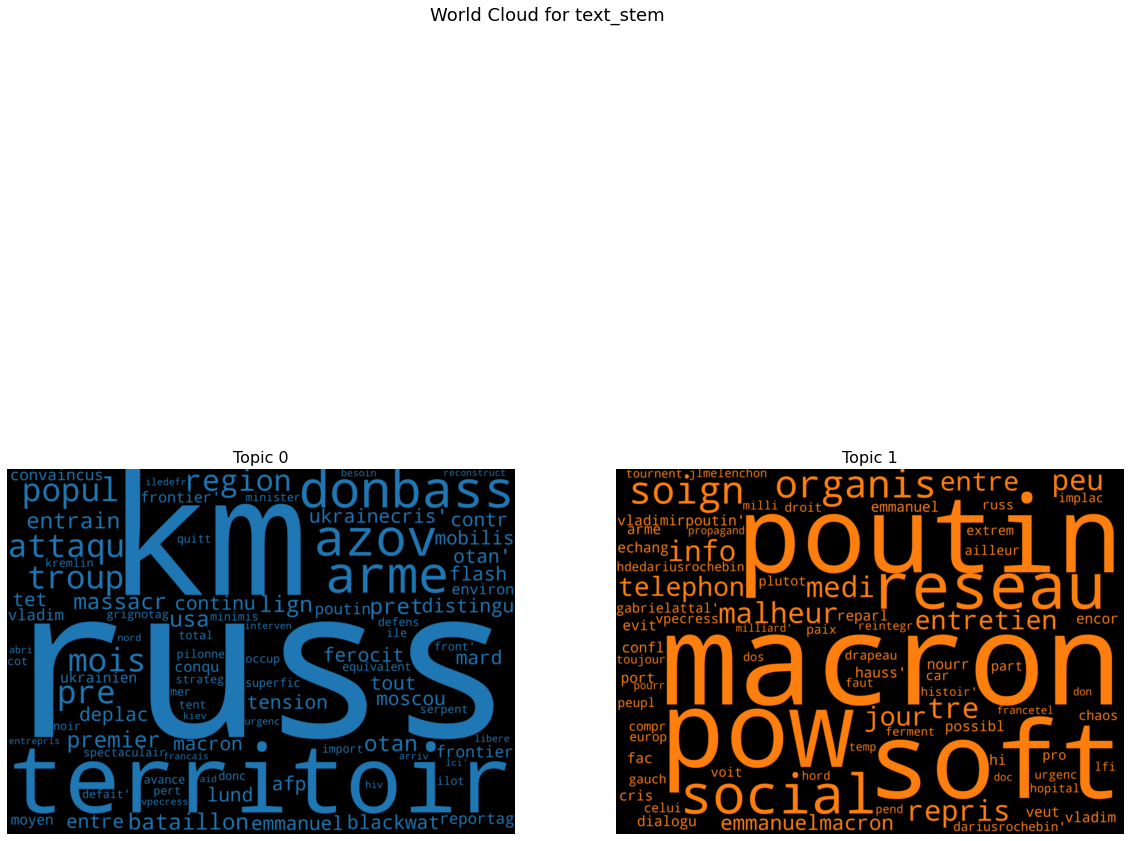

In [29]:
#run_all(data.copy(deep=True), "text_stem", "stem", True)

In [17]:
df_stem_bigrame_4topics = pd.read_csv("~/PycharmProjects/twitter_text_mining/output/dominant_topics_stem_bigrame_4topics.csv",
                              sep=";")

In [18]:
for i in df_stem_bigrame_4topics["dominant_topic"].unique():
    display(df_stem_bigrame_4topics[df_stem_bigrame_4topics["dominant_topic"]==i].sort_values(by=["dominant_topic", "topic_perc_contrib"], ascending=[True, False]).head(25))

tweet_id  index  \
15469  1512509710464868359  15491   
5193   1497981805898706945   5201   
5343   1498011100322975746   5351   
252    1492205874517061634    252   
10007  1501108342390935553  10020   
5985   1498331392794578948   5993   
2279   1496862717583495174   2280   
15354  1512098250559479816  15376   
17525  1525517202279079937  17547   
14375  1508896211897569289  14396   
9480   1500525498753036296   9492   
14311  1508733421945827343  14332   
15455  1512450217714589699  15477   
5182   1497983514385469443   5190   
4158   1497557158673756167   4163   
4797   1497881975453069315   4804   
2170   1496845482345259019   2171   
6301   1498469084241047552   6309   
17487  1525232549211082752  17509   
3040   1497136644993998880   3042   
15110  1511360431423643651  15131   
15514  1512745694108520448  15536   
2653   1496944905343709185   2655   
3717   1497335052111392771   3722   
7249   1498923573704069127   7257   

                                                                                                                                                                                                                                                                                                                                        text  \
15469                                      ursula von der leyen s'est rendue à boutcha, lieu d'atrocités en #ukraine\r\n\r\nursula von der leyen, qui est accompagnée du chef de la diplomatie européenne, josep borrell, avait annoncé vendredi se rendre dans la capitale en signe de soutien à l'ukraine. \r\n\r\nhttps://t.co/gzafdaowsb   
5193                                         @vonderleyen l'ue va financer l'achat et la livraison d'armements et d'autres équipements à l'#ukraine face à l'invasion russe, a annoncé  la présidente de la commission européenne, ursula von der leyen, précisant qu'il s'agissait d'une première pour l'union #afp https://t.co/iuefjh7w8w   
5343                              [a la une a 20h]\r\nl'ue va financer l'achat et la livraison d'armements et d'autres équipements à l'#ukraine face à l'invasion russe, a annoncé  la présidente de la commission européenne, ursula von der leyen, précisant qu'il s'agissait d'une première pour l'union #afp 5/5 https://t.co/gyal2jqwtj   
252                                                   #ukraine : les sanctions de l'ue en cas d'intervention de la russie frapperont les secteurs financier et énergétique, ainsi que les exportations de produits de haute technologie, annonce la présidente de la commission européenne ursula von der leyen #afp https://t.co/yqz4ghdaxs   
10007                                                              #ukraine : les danois ont de la chance. ils vont être consultés par référendum sur la défense européenne. et si on demandait l'avis des français ? sont-ils prêts à mettre l'armée française sous le commandement d'ursula von der leyen ?\r\n\r\nhttps://t.co/jim7gngxad   
5985                                                                                     🔴 guerre en #ukraine\r\n\r\nursula von der leyen (@vonderleyen), présidente de la commission européenne, vient de rejoindre emmanuel #macron à l'@elysee.\r\n\r\n📺le point sur  #la26 #tf1info &gt; https://t.co/t5ediitfdj https://t.co/93olmkezrr   
2279                                      l'ue «préparée» à l'accueil de réfugiés ukrainiens, qui sont «bienvenus».\r\n\r\n«nous avons maintenant des plans d'urgence clairement définis pour accueillir et héberger immédiatement les réfugiés d'ukraine», a déclaré ursula von der leyen.\r\n\r\n#ukraine  \r\n\r\nhttps://t.co/yycndffatp   
15354                                                                                                                                                    la présidente de la commission européenne, ursula von der leyen, se rendra à #kiev demain (vendredi) en signe de "soutien indéfectible" à l'#ukraine. (afp) https://t.co/bwqgt0mtbg   
17525                          

tweet_id  index  \
9359   1500443992105881600   9371   
9552   1500574759628812291   9565   
9850   1500883613688250369   9863   
10113  1501215883133399043  10126   
10458  1501579682852093954  10474   
10806  1501952361362702343  10823   
11099  1502347419601838082  11117   
11560  1503043471963209741  11580   
11813  1503417516093329414  11833   
12130  1503808908611227650  12150   
12317  1504128044902006788  12337   
12567  1504504634320338945  12587   
12710  1504861575890485256  12730   
13098  1505829340101152768  13119   
13155  1505917384548397062  13176   
13318  1506277585680015361  13339   
13749  1507040679490424838  13770   
13890  1507376614602153988  13911   
14242  1508440792678944775  14263   
14344  1508809826423517185  14365   
15103  1511357302686855173  15124   
15121  1511386500272996365  15142   
15200  1511662221222416386  15221   
15296  1511986107910656007  15317   
6740   1498664454489214976   6748   

                                                                                                                                                                                                                                                                                                             text  \
9359                                                                                                   l’offensive des forces armées russes se poursuit sur l’ensemble du territoire de l’ #ukraine. \r\n \r\nℹ️ situation au 5 mars 2022 → https://t.co/5bvhkwwguf \r\n \r\n@armees_gouv https://t.co/xklhuwzezv   
9552                                                                                                     l’offensive des forces armées russes se poursuit sur l’ensemble du territoire de l’ #ukraine. \r\n\r\nℹ️ situation au 6 mars 2022 → https://t.co/5bvhkwwguf \r\n\r\n@armees_gouv https://t.co/dwz0n7noyg   
9850                                                                                                       l’offensive des forces armées russes se poursuit sur l’ensemble du territoire de l'#ukraine. \r\n\r\nℹ️ situation au 7 mars 2022 → https://t.co/5bvhkwwguf\r\n\r\n@armees_gouv https://t.co/l9scu0tmrb   
10113                                                                                        l’offensive des forces armées russes se poursuit sur l’ensemble du territoire de l'#ukraine. \r\n\r\nℹ️ situation au 8 mars 2022 → https://t.co/5bvhkwwguf\r\n\r\n@armees_gouv \r\n\r\n[1/6] https://t.co/wwjj8xsz53   
10458                                                                                        l’offensive des forces armées russes se poursuit sur l’ensemble du territoire de l'#ukraine. \r\n\r\nℹ️ situation au 9 mars 2022 → https://t.co/5bvhkwwguf\r\n\r\n@armees_gouv \r\n\r\n[1/6] https://t.co/xrhf0apaad   
10806                                                                                       l’offensive des forces armées russes se poursuit sur l’ensemble du territoire de l'#ukraine. \r\n\r\nℹ️ situation au 10 mars 2022 → https://t.co/5bvhkwf55f\r\n\r\n@armees_gouv \r\n\r\n[1/6] https://t.co/idzoudvhgr   
11099                                                                                   l’offensive des forces armées russes se poursuit sur l’ensemble du territoire de l'#ukraine. \r\n\r\nℹ️ situation au 11 mars 2022 → \r\nhttps://t.co/5bvhkwwguf\r\n\r\n@armees_gouv \r\n\r\n[1/5] https://t.co/esccs04bvs   
11560                                                                                     l’offensive des forces armées russes se poursuit sur l’ensemble du territoire de l'#ukraine.  \r\n\r\nℹ️ situation au 13 mars 2022 → https://t.co/8zyf8loq90 \r\n\r\n@armees_gouv \r\n\r\n[1/5] https://t.co/qsy6k9yajs   
11813                                                                                      l’offensive des forces armées russes se poursuit sur l’ensemble du territoire de l'#ukraine.  \r\n\r\nℹ️ situation au 14 mars 2022 → https://t.co/5bvhkwwguf\r\n\r\n@armees_gouv\r\n \r

tweet_id  index  \
14971  1511029618718957568  14992   
15914  1514842860398551040  15936   
15934  1514949800084619265  15956   
16537  1519192171710193665  16559   
16765  1520650539318525952  16787   
18889  1537387819261382656  18913   
15445  1512415756960608258  15467   
19412  1540961454555275265  19436   
15947  1515005126511149060  15969   
17095  1522828055143665664  17117   
15997  1515325232898265088  16019   
17972  1529553857029840899  17995   
14926  1510922660213055488  14947   
15712  1513838445852037122  15734   
16024  1515566827530862592  16046   
15041  1511239516048310272  15062   
72     1490389133918887940     72   
167    1491006896043606017    167   
16892  1521420725785178112  16914   
9661   1500758836034129923   9674   
9756   1500821167510278144   9769   
12293  1504110677404835846  12313   
12314  1504128567508336642  12334   
12385  1504171772047941634  12405   
14671  1510161553349398532  14692   

                                                                                                                                                                                                                                                                                                                                         text  \
14971                               👇😂👍certains aiment #macrn à la folie.\r\nça les #medias en #france ne vous en parleront pas !\r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/mrtimcmoou   
15914                      👇🧐tout est devant nos yeux il suffit de les ouvrir !\r\n#medias #france #rothschildgate #macrondegage \r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/ey9cvidvbr   
15934                      👇🧐tout est devant nos yeux il suffit de les ouvrir !\r\n#medias #france #rothschildgate #macrondegage \r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/zsetdnnpr7   
16537                                                                    1/2 ça les #medias en #france ne vous en parleront pas !\r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/lo1mz6qgpy   
16765                                                                    1/2 ça les #medias en #france ne vous en parleront pas !\r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine https://t.co/7f2etfmozf   
18889                                ça les #medias en #france ne vous en parleront pas de cette manière !\r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine #billgatesbioterrorist https://t.co/1cemnlhou6   
15445                                           👇🧐on n'est jamais si bien servi que par soi-même !\r\n#france #medias #touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #castex #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine #rotschildgate https://t.co/ohkccjthoe   
19412                                  🧐👇et il achète également les #medias en #france à coup de millions de 💲\r\n\r\n#touscontremacron #mckinsey #mckinseygate #mckinseymacrongate #macron #veran #occitanie #toulouse #montpellier #herault #beziers #gard #nimes #perpignan #covid #ukraine #billgatesbioterrorist https://t.co/zriynap3bx   
15947                 

tweet_id  index  \
15609  1513137392588361746  15631   
15666  1513529143685795843  15688   
15779  1514240024811905027  15801   
15865  1514582503650213888  15887   
16003  1515370469674958864  16025   
16046  1515748331099770881  16068   
16088  1516102618535366659  16110   
16149  1516404097100001281  16171   
16268  1517156592327688192  16290   
16309  1517497051063496704  16331   
16370  1517921501030322176  16392   
16435  1518569662602256386  16457   
16490  1518933217373564931  16512   
16572  1519367842013093888  16594   
16605  1519648583263428608  16627   
16676  1520044173210144769  16698   
16743  1520411341919559680  16765   
16807  1520819033746161665  16829   
16911  1521510114376695809  16933   
16950  1521789817926868994  16972   
17075  1522601697587220480  17097   
17116  1522940274208509953  17138   
17162  1523249170936905733  17184   
17246  1523663029266968576  17268   
17297  1523958986449592321  17319   

                                                                                                                                                                                                                                                                                                     text  \
15609   📍point de situation en #ukraine au 10/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense \r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
15666  📍point de situation en #ukraine au 11/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise ⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense \r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
15779     📍point de situation en #ukraine au 13/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense\r\n@florence_parly @hervegrandjean @gouvernementfr @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
15865   📍point de situation en #ukraine au 14/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense \r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
16003  📍point de situation en #ukraine au 16/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise. ⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense\r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
16046  📍point de situation en #ukraine au 17/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise ⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense \r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
16088    📍point de situation en #ukraine au 18/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense\r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
16149   📍point de situation en #ukraine au 19/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise⤵️\r\nhttps://t.co/pxnd7xlsgm\r\n#notredéfense \r\n@florence_parly @hervegrandjean @gouvernementfr  @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
16268    📍point de situation en #ukraine au 21/04/2022.\r\nretrouvez toutes les informations pour mieux comprendre les enjeux de cette crise ⤵️\r\nhttps://t.co/pxnd7xdt8k\r\n#notredéfense\r\n@florence_parly @hervegrandjean @gouvernementfr @etatmajorfr @armeedeterre @armee_de_lair @marinenationale   
16309   📍point de situation en #ukraine au 22

===== Method : stem_bigrame =====
... Running bag of words
... Running lda with 3 topics
=== LDA model with 3 topics took : 0.82 minutes
Topic: 0 -> Words: 0.030*"union_europeen" + 0.028*"statut_candidat" + 0.023*"centr_commercial" + 0.017*"arme_ukrainien" + 0.015*"frederic_leclerc" + 0.015*"leclerc_imhoff" + 0.014*"mer_noir" + 0.014*"ile_serpent" + 0.013*"affair_etranger" + 0.012*"forc_russ"
Topic: 1 -> Words: 0.021*"reseau_social" + 0.017*"peupl_ukrainien" + 0.014*"accord_minsk" + 0.012*"militair_donbass" + 0.011*"ukrainien_standwithukrain" + 0.010*"president_emmanuelmacron" + 0.010*"cart_militair" + 0.010*"sanction_contr" + 0.010*"canon_caesar" + 0.010*"quelqu_jour"
Topic: 2 -> Words: 0.035*"emmanuel_macron" + 0.027*"vladim_poutin" + 0.020*"volodymyr_zelensky" + 0.016*"mieux_comprendr" + 0.015*"tout_inform" + 0.015*"retrouv_tout" + 0.015*"comprendr_enjeux" + 0.015*"cris_notredefens" + 0.015*"inform_mieux" + 0.015*"enjeux_cris"
=== Coherence Score: 0.62
... Running lda visualization


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


... Graph word cloud for each topic

 Total running time: 15.889149562517803 minutes


index  \
tweet_id                     
1488433061196812291      0   
1488447673883676672      1   
1488493240475078658      2   
1488502446771081216      3   
1488511509961527302      4   
...                    ...   
1542967067611127813  19732   
1542963887175335937  19733   
1542971236459888641  19734   
1542969041161158656  19735   
1542981780092985344  19736   

                                                                                                                                                                                                                                                                                                                                        text  \
tweet_id                                                                                                                                                                                                                                                                                                                                       
1488433061196812291                                                                                                                               voilà l'info, malheureusement très peu reprise par les #medias: \r\n2e entretien téléphonique en 4 jours entre #emmanuelmacron et #vladimirpoutine sur l'#ukraine. https://t.co/yyxetpnxuc   
1488447673883676672                                                                                                                                                                                                                                               #ukraine face à poutine ... macron hausse le ton ! https://t.co/mfpsevidlv   
1488493240475078658                                                                          crise en #ukraine : « emmanuel #macron et vladimir #poutine, se sont reparlés hier soir. il y a un dialogue et des échanges nourris. on veut éviter un conflit armé à nos portes. c'est encore possible » @gabrielattal https://t.co/v7ovwb9n4i   
1488502446771081216                           la #russie c'est l'équivalent du pib de l'italie. attention aux sanctions qu'elle pourrait recevoir et monsieur poutine est réaliste. on a loupé la relation avec la russie il y a une quinzaine d'années : elle devra être reconstruite dans l'avenir. #kiev #ukraine https://t.co/b15g66ehvl   
1488511509961527302                                                                                                                                                      crise en #ukraine : voilà pourquoi il faut sortir du piège atlantiste, refuser la guerre et quitter l’otan sur le champ ! nouvelle vidéo ➡️ https://t.co/qjyacvg9pk   
...                                                                                                                                                                                                                                                                                                                                      ...   
1542967067611127813                                                                                                                                                                                                                                    c'est magnifique et tellement émouvant 🥰🇺🇦🇪🇺 #ukraine #europe https://t.co/0ywt0zwqot   
1542963887175335937  👉 guerre un #ukraine : que faire pour aider les populations ?\r\n\r\n🗣️ @vpecresse \r\n"il y a urgence : l'hiver qui arrive. il faut mettre à l'abri les populations, reconstruire avant l'hiver [...] il faut investir massivement dans les régions libérées."\r\n\r\n📺 #le20hdedariusrochebin https://t.co/rh8jkshhcs   
1542971236459888641          👉 guerre en #ukraine : le soft power des réseaux sociaux\r\n\r\n🗣️ @vpecresse\r\n\r\n"on peut organiser le chaos à partir de ce soft power des réseaux sociaux [...] on le voit d'ailleurs car nos extrémistes sont plutôt pro russes."\r\n\r\n📺 

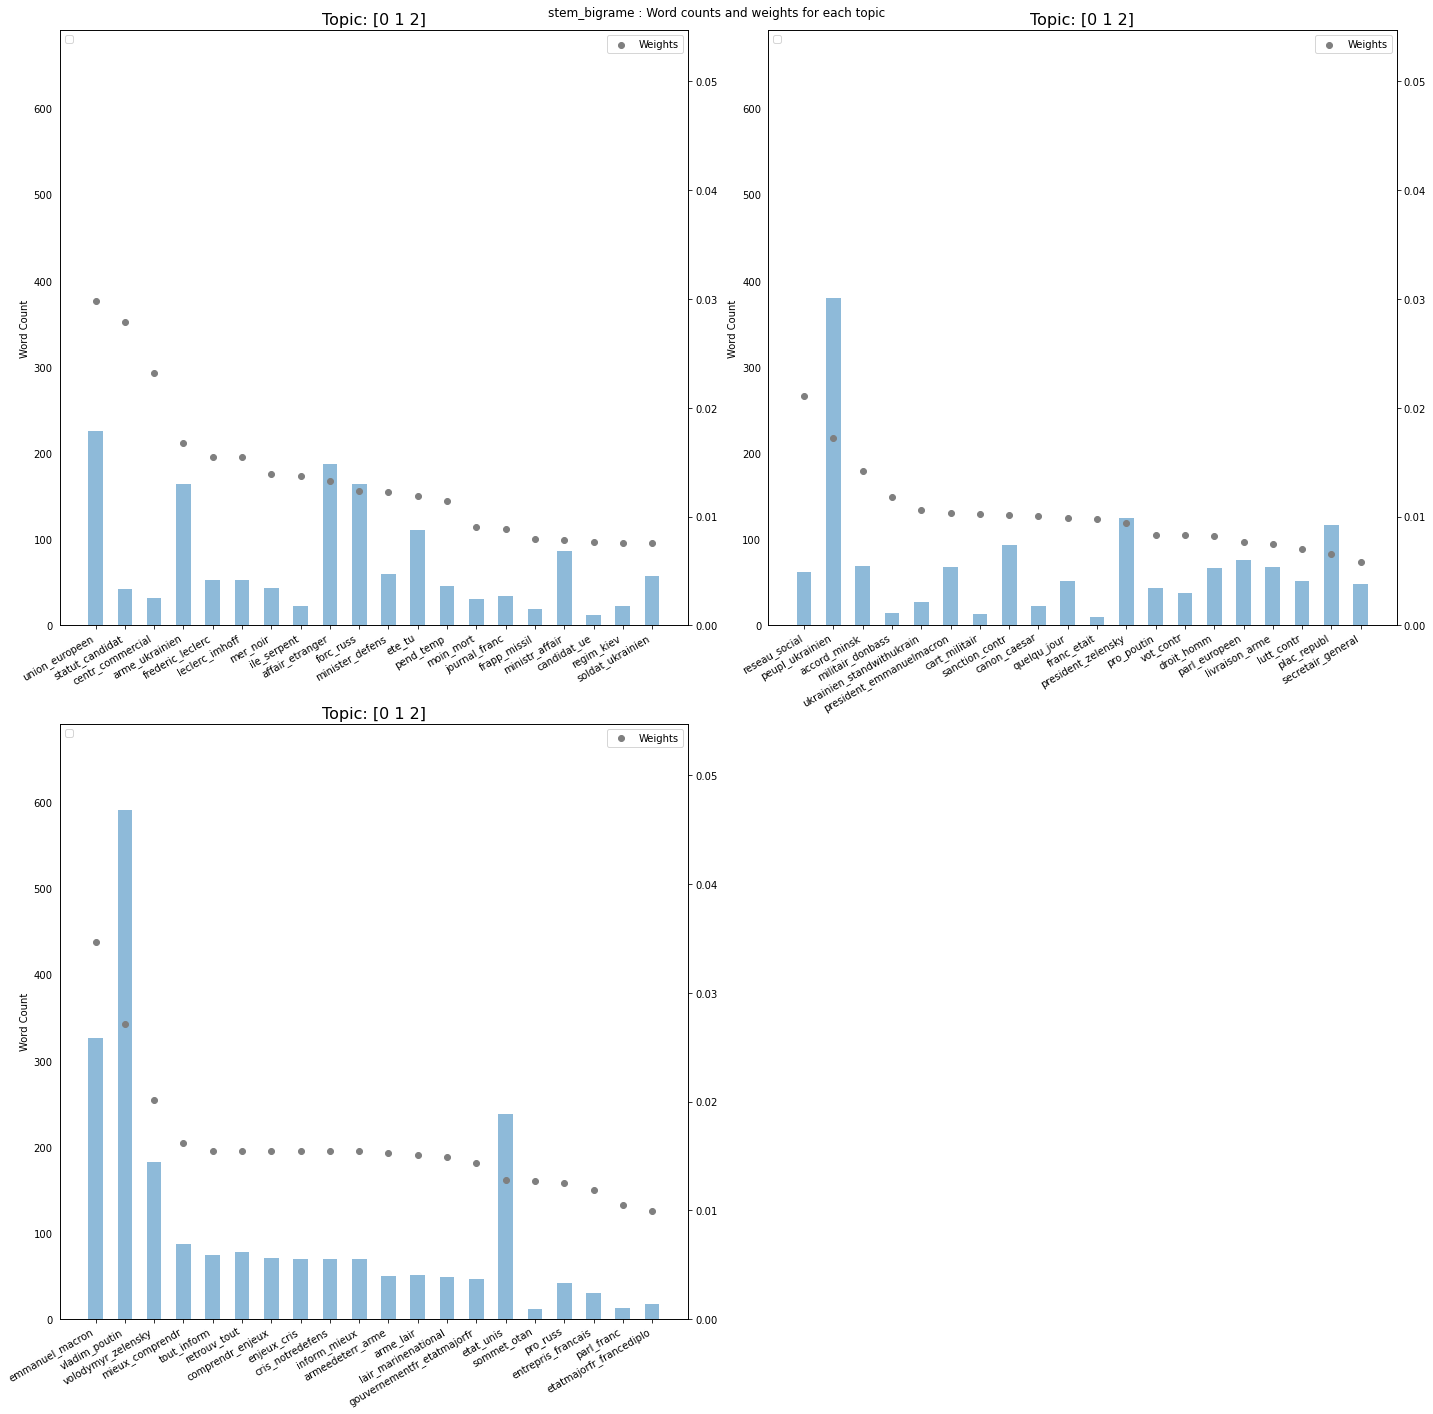

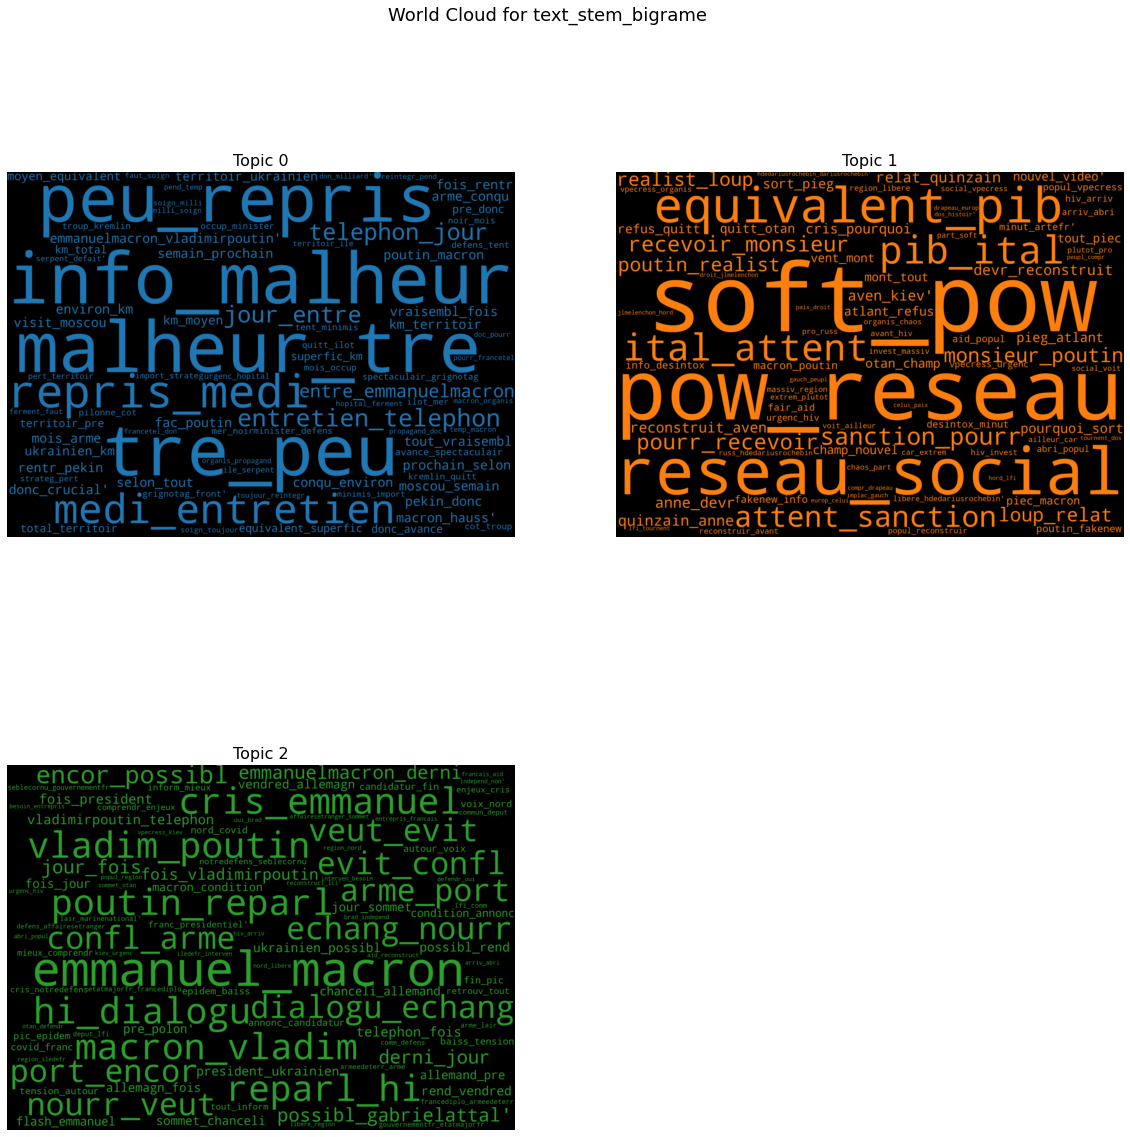

In [19]:
run_all(data.copy(deep=True), "text_stem_bigrame", "stem_bigrame", False, 3)

===== Method : stem_bigrame =====
... Running bag of words
... Running lda with 4 topics
=== LDA model with 4 topics took : 0.83 minutes
Topic: 0 -> Words: 0.041*"union_europeen" + 0.030*"centr_commercial" + 0.023*"arme_ukrainien" + 0.018*"affair_etranger" + 0.017*"minister_defens" + 0.016*"entrepris_francais" + 0.014*"parl_franc" + 0.013*"quelqu_jour" + 0.012*"moin_mort" + 0.012*"canon_caesar"
Topic: 1 -> Words: 0.020*"accord_minsk" + 0.015*"militair_donbass" + 0.015*"president_emmanuelmacron" + 0.014*"sanction_contr" + 0.014*"cart_militair" + 0.014*"franc_etait" + 0.013*"president_zelensky" + 0.011*"regim_kiev" + 0.011*"cris_alimentair" + 0.010*"alimentair_mondial"
Topic: 2 -> Words: 0.049*"emmanuel_macron" + 0.041*"statut_candidat" + 0.038*"vladim_poutin" + 0.028*"volodymyr_zelensky" + 0.018*"sommet_otan" + 0.018*"etat_unis" + 0.018*"pro_russ" + 0.017*"pend_temp" + 0.013*"chef_etat" + 0.012*"securit_alimentair"
Topic: 3 -> Words: 0.024*"reseau_social" + 0.020*"peupl_ukrainien" + 0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


... Graph word cloud for each topic

 Total running time: 14.921083947022757 minutes


index                                               text  \
tweet_id                                                                        
1488433061196812291      0  voilà l'info, malheureusement très peu reprise...   
1488447673883676672      1  #ukraine face à poutine ... macron hausse le t...   
1488493240475078658      2  crise en #ukraine : « emmanuel #macron et vlad...   
1488502446771081216      3  la #russie c'est l'équivalent du pib de l'ital...   
1488511509961527302      4  crise en #ukraine : voilà pourquoi il faut sor...   
...                    ...                                                ...   
1542967067611127813  19732  c'est magnifique et tellement émouvant 🥰🇺🇦🇪🇺 #...   
1542963887175335937  19733  👉 guerre un #ukraine : que faire pour aider le...   
1542971236459888641  19734  👉 guerre en #ukraine : le soft power des résea...   
1542969041161158656  19735  implacable. a gauche le peuple d’#ukraine qui ...   
1542981780092985344  19736  les urgences d'un hôpital ferment faute de soi...   

                            username  \
tweet_id                               
1488433061196812291        tcabarrus   
1488447673883676672          lapin47   
1488493240475078658  FaireEnsembleEM   
1488502446771081216  BrunoRetailleau   
1488511509961527302      f_philippot   
...                              ...   
1542967067611127813         Anna78__   
1542963887175335937              LCI   
1542971236459888641              LCI   
1542969041161158656      PJakubowicz   
1542981780092985344   LeDucDeLaToile   

                                                     text_stem_bigrame  \
tweet_id                                                                 
1488433061196812291  info_malheur malheur_tre tre_peu peu_repris re...   
1488447673883676672              fac_poutin poutin_macron macron_hauss   
1488493240475078658  cris_emmanuel emmanuel_macron macron_vladim vl...   
1488502446771081216  equivalent_pib pib_ital ital_attent attent_san...   
1488511509961527302  cris_pourquoi pourquoi_sort sort_pieg pieg_atl...   
...                                                                ...   
1542967067611127813                   magnif_tel tel_emouv emouv_europ   
1542963887175335937  fair_aid aid_popul popul_vpecress vpecress_urg...   
1542971236459888641  soft_pow pow_reseau reseau_social social_vpecr...   
1542969041161158656  implac_gauch gauch_peupl peupl_compr compr_dra...   
1542981780092985344  urgenc_hopital hopital_ferment ferment_faut fa...   

                     document_no  dominant_topic  topic_perc_contrib  \
tweet_id                                                               
1488433061196812291            0               1              0.3524   
1488447673883676672            1               0              0.4994   
1488493240475078658            2               2              0.6048   
1488502446771081216            3               1              0.3980   
1488511509961527302            4               0              0.2611   
...                          ...             ...                 ...   
1542967067611127813        19708               0              0.2611   
1542963887175335937        19709               0              0.2611   
1542971236459888641        19710               3              0.4311   
1542969041161158656        19711               0              0.2611   
1542981780092985344        19712               2              0.3751   

                                                              keywords  \
tweet_id                                                                 
1488433061196812291  accord_minsk, militair_donbass, president_emma...   
1488447673883676672  union_europeen, centr_commercial, arme_ukraini...   
1488493240475078658  emmanuel_macron, statut_candidat, vladim_pouti...   
1488502446771081216  accord_minsk, militair_donbass, president_emma...   
1488511509961527302  union_europeen, centr_commercial, arme_ukraini...   
...                         

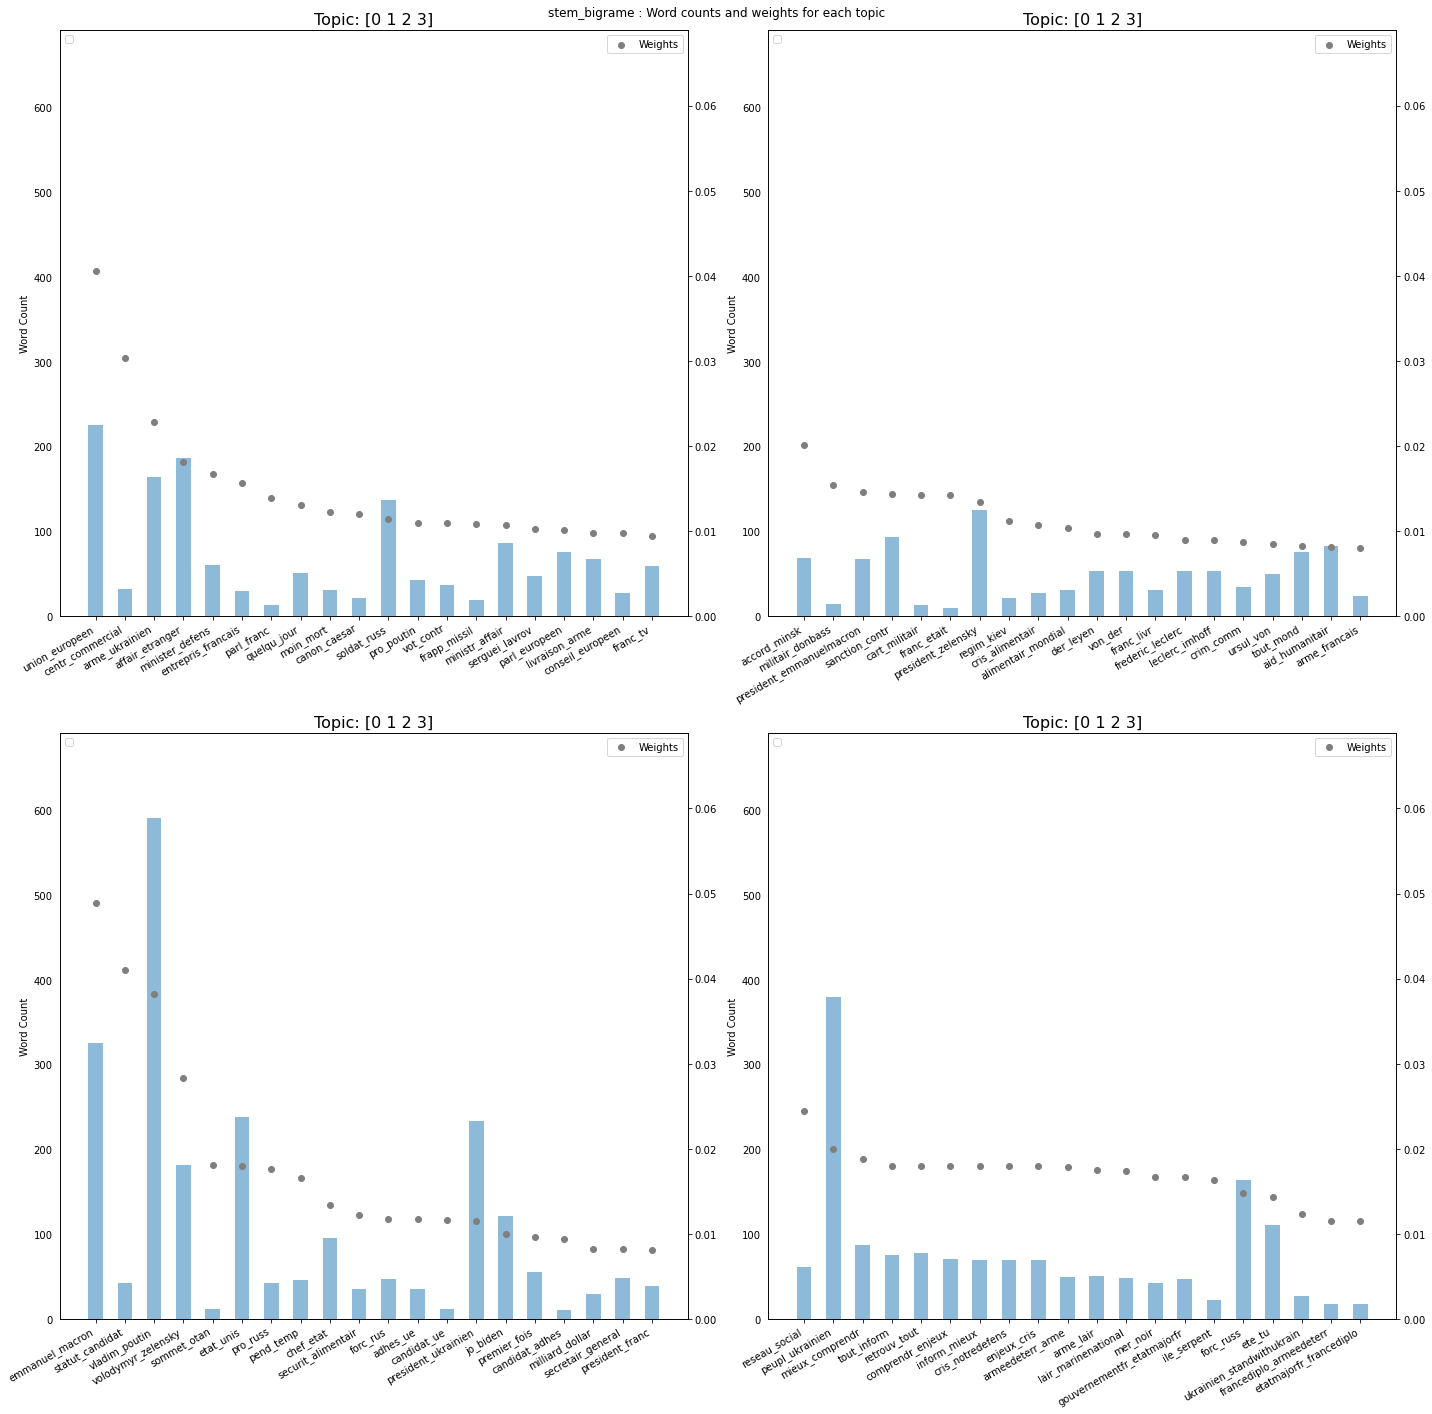

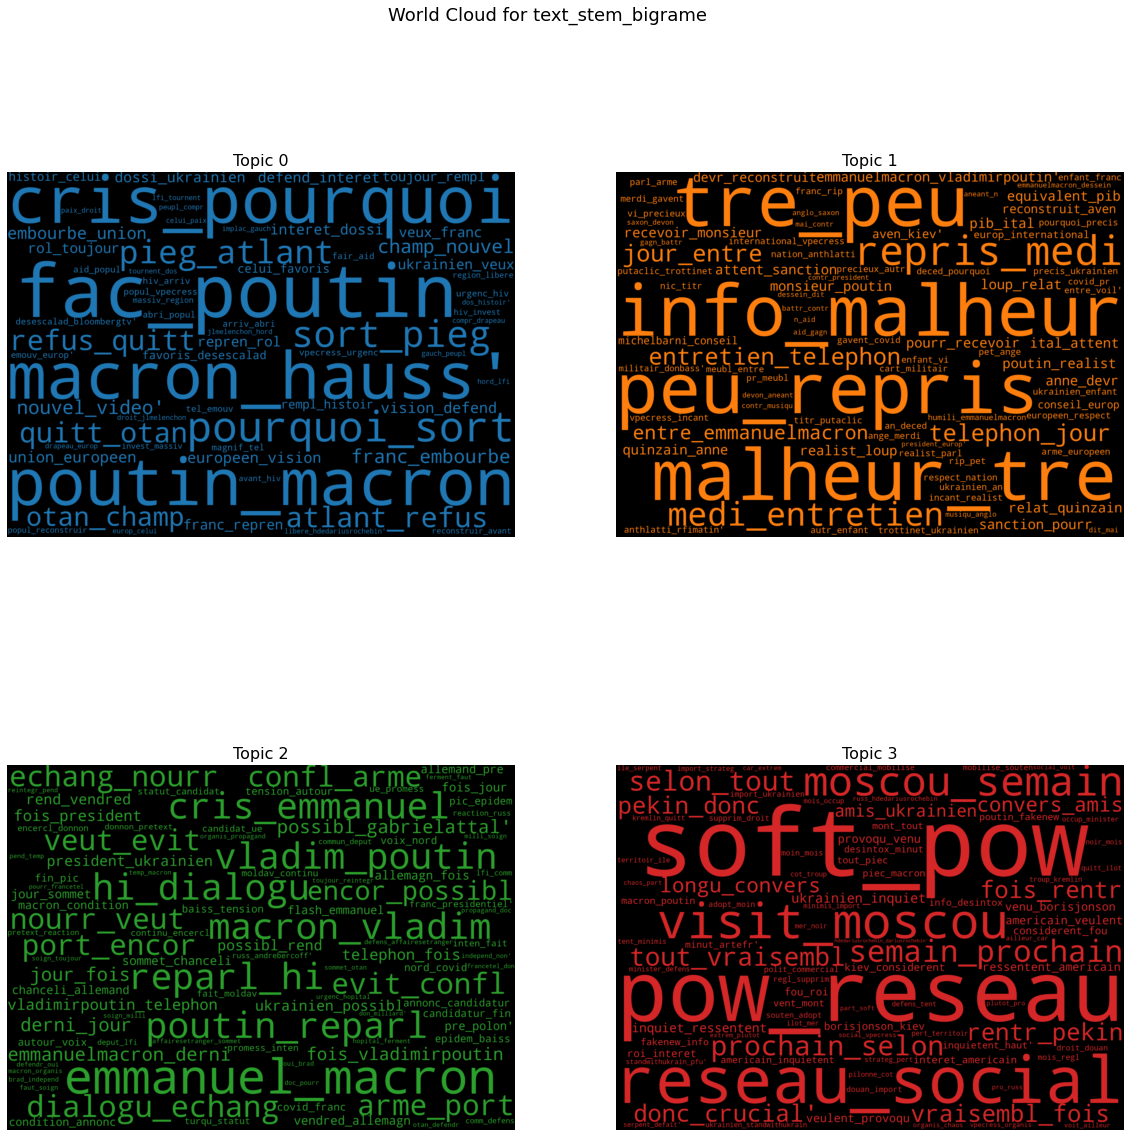

In [22]:
run_all(data.copy(deep=True), "text_stem_bigrame", "stem_bigrame", False, 4)

In [11]:
run_all(data.copy(deep=True), "text_stem_trigrame", "stem_trigrame", True)

===== Method : stem_trigrame =====
... Running bag of words
... Running search for best nb of topics


KeyboardInterrupt: 

In [ ]:
def read_outputs(alias, best_topics):
    import matplotlib.image as mpimg
    # read an image
    #nb_topics = mpimg.imread(f"output/img/search_nbtopics_{alias}.png")
    bp = mpimg.imread(f"output/img/{alias}.png")
    wc = mpimg.imread(f"output/img/world_cloud_{alias}.png")
 
    # Output Images
    #bp.imshow(nb_topics)
    #plt.imshow(bp)
    #plt.imshow(wc)

    df_dominant_topics = pd.read_csv(f"output/dominant_topics_{alias}_{best_topics}topics.csv",
                              sep=";")
    return(df_dominant_topics)


In [ ]:
read_outputs(alias="stem_bigrame", best_topics=3)

In [ ]:
data.reset_index()["text_stem_trigrame"][:10]

In [ ]:
data["text_stem_trigrame"].dtypes

In [ ]:
df_trigrame = pd.read_csv("~/PycharmProjects/twitter_text_mining/output/dominant_topics_stem_trigrame_5topics.csv", sep=";")
df_trigrame.head()

In [ ]:
df_trigrame["dominant_topic"]

In [ ]:
# filtrer les chaines d'info ==> exclure 
print("... Deleting stop words")
list_stop_words = ["inform_mieux_comprendr", "situat_retrouv_tout", "tout_inform_mieux",
                  "retrouv_tout_inform", "point_situat_retrouv", "mieux_comprendr_enjeux",
                  "arme_lair_marinenational", "enjeux_cris_notredefens", "comprendr_enjeux_cris"]
data = data[data["text_stem_trigrame"].notnull()]
data["text_stem_trigrame"] = data["text_stem_trigrame"].apply(
    lambda x: ' '.join([word for word in x.split(" ") if word not in (
        list_stop_words)])
        )


df_trigrame = run_all(data.copy(deep=True), "text_stem_trigrame", "stem_trigrame", False, 3)

In [ ]:
df_trigrame

In [ ]:
run_all(data.copy(deep=True), "text_stem_bigrame", "stem_bigrame", False, nb_topics=3)

In [ ]:
df_dominant_stem[df_dominant_stem["dominant_topic"]==0]["text_stem"].values

In [ ]:
df_dominant_topics_lemma = format_topics_sentences(ldamodel=lda_lemma, corpus=doc_term_matrix_lemma, texts=text_tokens_lemma)
df_dominant_topics_stem = format_topics_sentences(ldamodel=lda_stem, corpus=doc_term_matrix_stem, texts=text_tokens_stem)
df_dominant_topics_bigrame = format_topics_sentences(ldamodel=lda_bigram, corpus=doc_term_matrix_bigram, texts=text_tokens_bigram)
df_dominant_topics_trigram = format_topics_sentences(ldamodel=lda_trigram, corpus=doc_term_matrix_trigram, texts=text_tokens_trigram)
df_dominant_topics_stem_bigrame = format_topics_sentences(ldamodel=lda_stem_bigram, corpus=doc_term_matrix_stem_bigram, texts=text_tokens_stem_bigram)
df_dominant_topics_stem_trigram = format_topics_sentences(ldamodel=lda_stem_trigram, corpus=doc_term_matrix_stem_trigram, texts=text_tokens_stem_trigram)

In [ ]:
 # todo: FIXME add this information some where in a function
original_cols = ["text_lemma", "text_lemma_bigrame",
    "text_stem_trigrame", "text_stem",
    "text_stem_bigrame", "text_lemma_trigrame",
    "text_lemma", "text_stem_trigrame", 
    "text_stem"]

In [ ]:
sent_topics_sorteddf_mallet.shape

In [ ]:
df_dominant_topics.head()

In [ ]:
fig = px.bar(df_dominant_topics, x=' 	Dominant_Topic', y='pop')

### La sentence la plus représentative de chaque topic

In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_dominant_topics.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative_Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
from plotly.subplots import make_subplots

nb_topics = df["topic_id"].unique()
fig = make_subplots(rows=len(nb_topics), cols=1, start_cell="bottom-left",
                   subplot_titles= ("topic 1", "topic 2", "topic 3", "topic 4", "topic 5"))
for i in nb_topics:
    print(i)
    fig.add_trace(go.Bar(x=df[df['topic_id']==i]["word"], y=df[df['topic_id']==i]['word_count']),
                        row=i+1, col=1)
    fig.update_layout(barmode='stack',
                      xaxis={'categoryorder': 'total descending'})
fig.show()


fig = make_subplots(rows=len(nb_topics), cols=1, start_cell="bottom-left",
                   subplot_titles= ("topic 1", "topic 2", "topic 3", "topic 4", "topic 5"))
for i in nb_topics:
    print(i)
    sizeref = df[df['topic_id']==i]["importance"].max() / 100 ** 2

    fig.add_trace(go.Scatter(x=df[df['topic_id']==i]["importance"],
                             y=df[df['topic_id']==i]['word_count'],
                             text=df[df['topic_id']==i]["word"],
                             marker_size=df[df['topic_id']==i]["importance"]),
                        row=i+1, col=1)
    fig.update_traces(mode='markers', marker=dict(sizemode='area',
                                              line_width=2))
fig.show()

# fig = px.scatter(df[df['topic_id']==0], x="importance", y='word_count', color='word', size='importance' )
# fig.show()

In [ ]:
topics = lda_lemma.show_topics(formatted=False)
data_flat = [word for word_list in text_tokens_lemma for word in word_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 

In [ ]:
### Word count and importance of key terms into the "optimal" topics

In [ ]:

make_cloud(data, df_dominant_topics_lemma, "lemma")
make_cloud(data, df_dominant_topics_bigrame, "lemma_bigrame")
make_cloud(data, df_dominant_topics_stem, "stem")

In [ ]:
all_files = [df_dominant_topics_lemma, df_dominant_topics_stem, df_dominant_topics_bigrame,
            df_dominant_topics_trigram,  df_dominant_topics_stem_bigrame, df_dominant_topics_stem_trigram]
for i,file in enumerate(all_files):
    file.to_csv(f"output/{i}.csv", sep=";")

In [ ]:
files = os.listdir(path + "/output/")
files_tw = []
for filename in files:
    try:
        tmp = re.search(r"dominant_.*\.csv\b", filename)[0]
        files_tw.append(tmp)
    except TypeError:
        pass

print(files_tw)



In [ ]:
df_dominant_topics_lemma.head()

In [ ]:
# Assign a topic to each tweet 
def format_topics_sentences(ldamodel, corpus, texts):
        
        # Init output
        sent_topics_df = pd.DataFrame()

        start = time.time()
        # Get main topic in each document
        for i, row_list in enumerate(ldamodel[corpus]):
            # per_word_topics: list of topics, sorted in descending order of most likely topics for each word
            row = row_list[0] if ldamodel.per_word_topics else row_list
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        end = time.time()
        delta = (end - start)/60
        print(f"Took {delta:.2} minutes")
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
        
        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

        # format
        sent_topics_df = sent_topics_df.reset_index()
        sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
        return(sent_topics_df)

def make_cloud(df, df_dominant_topic, vect_type):
    df[f"Dominant_Topic_{vect_type}"] = df_dominant_topic["Dominant_Topic"]
    color_list = ["summer", "winter", "Oranges", "seismic"]
    
    for i in df_dominant_topic["Dominant_Topic"].unique():
        color = random.choice(color_list)
        cloud = WordCloud(colormap=color, width=800, height=400).generate(str(
            df[df[f"Dominant_Topic_{vect_type}"]==i][f"text_{vect_type}"]))
        fig = plt.figure(figsize=(12,10))
        plt.axis("off")
        plt.imshow(cloud,interpolation='bilinear')
        plt.title(f"WordCloud for Topic {i}", size = 24)
        plt.show()

        cloud.to_file(f"output/img/{vect_type}_topic{i}.png")

# Assign a topic to each tweet 

In [ ]:
# trigrames stem
text_tokens_stem_trigram, dico_words_stem_trigram, doc_term_matrix_stem_trigram = compute_bag_of_words(data["text_stem_trigrame"])

best_topics_stem_trigram = search_nb_topics(dictionary=dico_words_stem_trigram,
                                                        corpus=doc_term_matrix_stem_trigram,
                                                        texts=text_tokens_stem_trigram,
                                                        start=2, limit=5, step=1)

lda_stem_trigram, score_stem_trigram = compute_lda(dictionary=dico_words_stem_trigram, corpus=doc_term_matrix_stem_trigram, texts=text_tokens_stem_trigram, num_topics=best_topics_stem_trigram)

vis = gensimvis.prepare(topic_model=lda_stem_trigram, corpus=doc_term_matrix_stem_trigram, dictionary=dico_words_stem_trigram)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_stem_trigram.html')

In [ ]:
# trigrames
text_tokens_trigram, dico_words_trigram, doc_term_matrix_trigram = compute_bag_of_words(data["text_lemma_trigrame"])

best_topics_trigram = search_nb_topics(dictionary=dico_words_trigram,
                                                        corpus=doc_term_matrix_trigram,
                                                        texts=text_tokens_trigram,
                                                        start=2, limit=10, step=1)

lda_trigram, score_trigram = compute_lda(dictionary=dico_words_trigram, corpus=doc_term_matrix_trigram, texts=text_tokens_trigram, num_topics=best_topics_trigram)

vis = gensimvis.prepare(topic_model=lda_trigram, corpus=doc_term_matrix_trigram, dictionary=dico_words_trigram)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_trigram.html')

In [ ]:
# bigramms with stemmatization
text_tokens_stem_bigram, dico_words_stem_bigram, doc_term_matrix_stem_bigram = compute_bag_of_words(data["text_stem_bigrame"])

#best_topics_stem_bigram = search_nb_topics(dictionary=dico_words_stem_bigram,
#                                                        corpus=doc_term_matrix_stem_bigram,
#                                                        texts=text_tokens_stem_bigram,
#                                                        start=2, limit=10, step=1)

lda_stem_bigram, score_stem_bigram = compute_lda(dictionary=dico_words_stem_bigram, corpus=doc_term_matrix_stem_bigram, texts=text_tokens_stem_bigram, num_topics=3)

vis = gensimvis.prepare(topic_model=lda_stem_bigram, corpus=doc_term_matrix_stem_bigram, dictionary=dico_words_stem_bigram)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_stem_bigram.html')

In [ ]:
# bigrammes
text_tokens_bigram, dico_words_bigram, doc_term_matrix_bigram = compute_bag_of_words(data["text_lemma_bigrame"])

#best_topics_bigram = search_nb_topics(dictionary=dico_words_bigram,
#                                                        corpus=doc_term_matrix_bigram,
#                                                        texts=text_tokens_bigram,
#                                                        start=2, limit=10, step=1)

lda_bigram, score_bigram = compute_lda(dictionary=dico_words_bigram, corpus=doc_term_matrix_bigram, texts=text_tokens_bigram, num_topics=5)

vis = gensimvis.prepare(topic_model=lda_bigram, corpus=doc_term_matrix_bigram, dictionary=dico_words_bigram)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_bigram.html')

In [ ]:
# stem
text_tokens_stem, dico_words_stem, doc_term_matrix_stem = compute_bag_of_words(data["text_stem"])
best_topics_stem = search_nb_topics(dictionary=dico_words_stem,
                                    corpus=doc_term_matrix_stem,
                                    texts=text_tokens_stem,
                                    start=2, limit=7, step=1)

lda_stem, score_stem = compute_lda(dictionary=dico_words_stem, corpus=doc_term_matrix_stem, texts=text_tokens_stem, num_topics=best_topics_stem)


vis = gensimvis.prepare(topic_model=lda_stem, corpus=doc_term_matrix_stem, dictionary=dico_words_stem)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_stem.html')

In [ ]:
#text_tokens_lemma, dico_words_lemma, doc_term_matrix_lemma = compute_bag_of_words(data["text_lemma"])
#best_topics_lemma = search_nb_topics(dictionary=dico_words_lemma,
#                                    corpus=doc_term_matrix_lemma,
#                                    texts=text_tokens_lemma,
#                                    start=2, limit=7, step=1)


lda_lemma, score_lemma = compute_lda(dictionary=dico_words_lemma, corpus=doc_term_matrix_lemma, texts=text_tokens_lemma, num_topics=3)


vis = gensimvis.prepare(topic_model=lda_lemma, corpus=doc_term_matrix_lemma, dictionary=dico_words_lemma)
pyLDAvis.enable_notebook()
#pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_lemma.html')

In [ ]:
data.iloc[11591]

In [ ]:
print(data["text"].iloc[11591])
print(data["text"].iloc[425])

In [ ]:
raw_data = read_files(os.path.join(path, "data/test/"))

In [ ]:


representative_sentence(test, data)

In [ ]:
test = zip (original_cols, files_tw)
for origin_col, file in test:
    _dominant = pd.read_csv(path + "/output/" + file, sep=";")
    _dominant = _dominant.drop("Unnamed: 0", axis=1)
    print(f"==== {file}")
    rep = representative_sentence(_dominant, data, origin_col)

In [ ]:
data.columns

In [ ]:
test = pd.read_csv("output/dominant_topics_lemma.csv", sep=";")
test.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
df_dominant_lemma_bigram[df_dominant_lemma_bigram["dominant_topic"]==1].sort_values(by=["dominant_topic", "topic_perc_contrib"], ascending=[True, False]).head(20)

In [ ]:
run_all(data["text_lemma"], "lemmatization", True)
run_all(data["text_lemma"], "lemmatization", False, 4)
run_all(data["text_stem"], "stemming", True)
run_all(data["text_lemma_bigrame"], "bigramLemmatization", True)
run_all(data["text_lemma_bigrame"], "bigramLemmatization", False, 3)
run_all(data["text_stem_bigrame"], "bigramStemming",  False, 4)
run_all(data["text_lemma_trigrame"], "trigramLemmatization", True)
run_all(data["text_stem_trigrame"], "trigramStemming", True)
run_all(data["text_stem_trigrame"], "trigramStemming", False, 3)



In [ ]:
def representative_sentence(df_topic, df_, col_):
    df_ = df_[df_[col_].notna()]
    print(df_.shape)
    sort_rep_topic = df_topic.sort_values(
        by=["Dominant_Topic", "Topic_Perc_Contrib"],
        ascending=[True,False])
    sort_rep_topic = sort_rep_topic.drop_duplicates(["Dominant_Topic"])
    
    # Format
    sort_rep_topic.columns = ["tweet_no", "dominant_topic",
                              "topic_perc_contrib",
                              "keywords", "representative_text"]
   
    for i, row in sort_rep_topic.iterrows():
        print(f"\n\nTopic number: {row['dominant_topic']}")
        print(row["representative_text"])
        print(" ===== Original tweet :")
        print(f"Author: {df_['username'].iloc[row['tweet_no']]}:")
        print(df_['text'].iloc[row['tweet_no']])
    
    return sort_rep_topic

In [ ]:
df_dominant_lemma_bigram = run_all(data.copy(deep=True), "text_lemma_bigrame", "lemmatization_bigram", False, 3)

In [ ]:
df_dominant_lemma[df_dominant_lemma["dominant_topic"]==0].sort_values(by=["dominant_topic", "topic_perc_contrib"], ascending=[True, False]).head(20)

In [ ]:
df_dominant_lemma = run_all(data.copy(deep=True), "text_lemma", "lemmatization", False, 4)

In [ ]:
df_dominant_stem[df_dominant_stem["dominant_topic"]==2].sort_values(by=["dominant_topic", "topic_perc_contrib"], ascending=[True, False]).head(20)

In [ ]:
df_dominant_stem = run_all(data.copy(deep=True), "text_stem", "stemming", False, 4)

In [ ]:
df_dominant_stem_bigram = run_all(data.copy(deep=True), "text_stem_bigrame", "stemming_bigram", False, 4)

In [ ]:
df_dominant_stem_bigram.head()

In [ ]:
df_tweets = data.copy(deep=True)
df_tweets = df_tweets[["tweet_id", "text", "username", "text_lemma"]]
df_text = data["text_lemma"]
alias = "lemmatization"

In [ ]:
df_tweets.head()

In [ ]:
df_test.head()

In [ ]:
df_dominant_topics

In [ ]:
df_dominant_topics_.head()

In [ ]:
df_dominant_topics_ = df_tweets.join(df_dominant_topics, how="inner" )
df_dominant_topics_ = df_dominant_topics_.set_index("tweet_id")

In [ ]:
df_tweets = data.copy(deep=True)
df_tweets = df_tweets[["tweet_id", "text", "username", "text_lemma"]]
df_tweets = df_tweets.reset_index(drop=True)
df_text = data["text_lemma"]
alias = "lemmatization"

#df_test  = pd.concat([df_dominant_topics.reset_index(), df_tweets.reset_index()], ignore_index=True, axis=1, )